## Chapter 13: Multi-layer Perceptrons 

# 13.1 Multi-layer perceptrons (MLPs)

Unlike polynomials and other fixed kernels, each unit of a neural network has internal parameters that can be tuned to give it a flexible shape. In this Section we detail multi-layer neural networks - often called *multi-layer perceptrons* or *deep feedforward neural networks*.  In the previous Chapter we introduced *single layer* perceptrons, and here we expand on that introduction extensively.  We will see how these recursively defined universal approximators are defined mathematically as well as implemented (as a `feature_transforms` function) that we can employ for any supervised or unsupervised learning task we wish.  

We begin by describing deep networks in the context of our previous discussion, as a particular catalog of nonlinear functions used for nonlinear learning problems.  Along the way we will describe these network elements from a graphical, algebraic, and computational perspective (implementing them as our `feature_transforms` function) so that we can better understand them.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import multilayer_perceptron_library as multi
from mlrefined_libraries import math_optimization_library as optlib
basic_runner = nonlib.basic_runner
regress_plotter = nonlib.nonlinear_regression_demos
classif_plotter = nonlib.nonlinear_classification_demos
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import basic plotting mechanisms
import matplotlib.pyplot as plt
from matplotlib import gridspec

# This is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

## 13.1.1 Single-layer units

At the heart of nonlinear learning is the following simple yet powerful idea: nonlinear curves of arbitrary shape can be modeled/approximated via a linear combination of simpler nonlinear functions (or units) of the input data. With neural networks each of these units is also parameterized with a number of weights to be tuned using data. Here we discuss in detail how to form neural network units starting with the simplest of them: a single-layer unit.  These are also often referred to as single *hidden* layer perceptrons as well.

### Graphical and algebraic representation of single layer units

Ever since Hippocrates argued, over two thousand years ago, that the brain was "the seat of the mind," scientists have been studying it with the hope of unlocking the secrets of human intelligence. In fact the field we know today as Artificial Intelligence (AI) was born in an ambitious quest to mathematically model the complex human brain. The first attempts were made in the 1940s [[1,2]](#bib_cell) by a group of psychologists and neuroscientists who proposed simplistic mathematical models for a single neuron (brain cell). These early models - later dubbed as artificial neurons - culminated in the introduction of the *perceptron* model [[3]](#bib_cell) in 1957.

Figure 1 shows a comparative illustration of a biological neuron (left) and a *perceptron* (right). The biological neuron consists of three main parts: *dendrites* (the neuron's receivers), *soma* (the cell body), and *axon* (the neuron's transmitter). Closely mimicking this structure, an artificial neuron comprises a set of dendrite-like edges, each taking an input and multiplying it by a (synaptic) weight associated with that edge. These weighted inputs are summed up after going through a *summation unit* (shown in the figure by a small hollow circle). The result is subsequently fed to an *activation unit* (shown by a large blue circle) whose output is then transmitted to the outside via an axon-like projection. Notice how the output of the perceptron model takes the same form as a single-layer basis function derived in Subsection 1.1.1. The graphical model shown in the right panel of Figure 1 is therefore commonly used to visually represent a single-layer neural network basis function.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/bio_v_art.png" width="100%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> (left) A typical biological neuron. (right) An artificial neuron (perceptron). A perceptron is a simplistic mathematical model for the biological neuron consisting of: (i) weighted edges that represent the individual multiplications (of $1$ by $w_{0}$, $x_1$ by $w_{1}$, etc.), (ii) a summation unit shown as a small hollow circle representing the sum $w_0+w_{1}\, x_1+\cdots+w_{N}\, x_N$, and (iii) an activation unit shown as a larger blue circle representing the sum evaluated by the nonlinear activation function $a$. </em>
</figcaption>
</figure>

From a biological perspective, neurons are believed to remain inactive until the net input to the cell body (soma) reaches a certain threshold, at which point the neuron gets *activated* and fires an electro-chemical signal, hence the name *activation function*.

The algebraic representation of the sort of single-layer unit function shown in the Figure above is quite simple: a linear combination of the input passed through a nonlinear activation function

\begin{equation}
f^{(1)}\left(\mathbf{x}\right)=a\left(w^{\left(1\right)}_{0}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n}\,x_n}\right).
\end{equation}

The superscripts on  $f$ and $w_0, w_1, \ldots, w_N$ indicate they represent a single-layer function and its internal weights respectively. Because we will want to extend the single layer idea to create deeper - multilayer - perceptrons, we will find that it is easier to describe this sort of function as a sequence of two operations: the linear combination of input, passed through a nonlinear activation.  We refer to this manner of writing out the function as the *recursive recipe for creating single layer perceptron units* and show it below.

#### Recursive rescipe for single layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$<br>

<strong>2:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\,\,\, v = w_{0}^{(1)}+{\sum_{n=1}^{N}}{w_{n}^{(1)}\,x_n}$ <br>

<strong>3:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\, a\left(v\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; <strong>output:</strong> Single layer unit $\,\, a\left(v\right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 1. </span> The shape of single-layer functions with $\text{tanh}$ activation 

In the Python cell below we plot four instances of a single-layer unit using $\text{tanh}$ as nonlinear activation function. These take the form 

\begin{equation}
f^{(1)}(x) = \text{tanh}\left(w_0^{(1)} + w_1^{(1)}x\right)
\end{equation}

In each instance the internal parameters have been set randomly, giving each basis function a distinct shape.

<IPython.core.display.Javascript object>


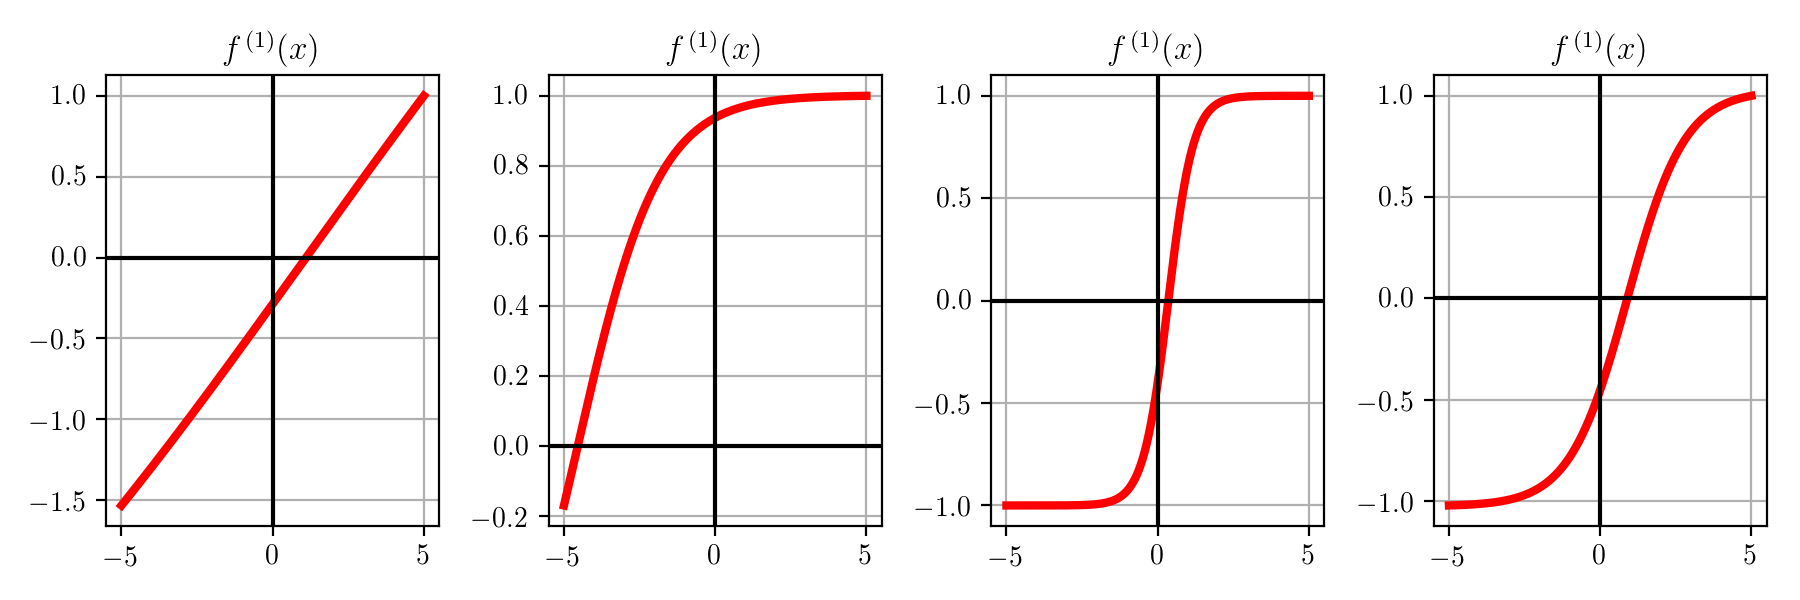

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of a single layer basis
demo.show_1d_net(num_layers = 1, activation = 'tanh')

#### <span style="color:#a50e3e;">Example 2. </span> The shape of single-layer functions with ReLU activation 

We repeat the experiment in Example 1, this time swapping $\text{tanh}$ for ReLU as activation, i.e., they take the form

\begin{equation}
f^{(1)}(x) = \text{max}\left(0,w_0^{(1)} + w_1^{(1)}x\right)
\end{equation}

In each instance the internal parameters have been set randomly, giving each basis function a distinct shape.

<IPython.core.display.Javascript object>


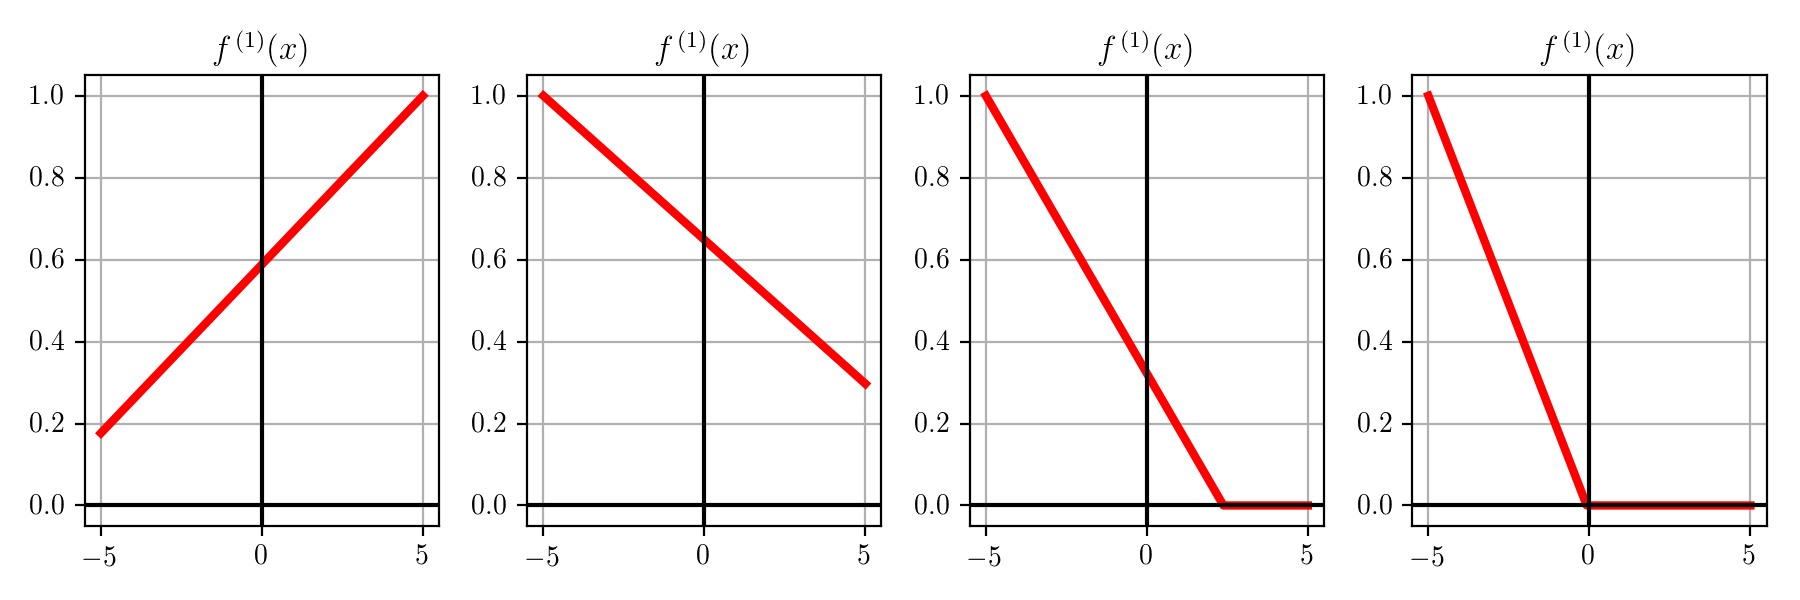

In [3]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of a single hidden layer basis
demo.show_1d_net(num_layers = 1, activation = 'relu')

---

In general we will want to compute $B = U_1$ such units - a number we define - as feature transformations in supervised / unsupervised learning `model` 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + f^{(1)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(1)}_{U_1}\left(\mathbf{x}\right)w_{U_1}
\end{equation}

as we described in the previous Chapter where we introduced the idea of nonlinear learning.  Notice in this case that each single layer unit now has its own internal parameters, the $j^{th}$ of which looks like 

\begin{equation}
f^{(1)}_j\left(\mathbf{x}\right)=a\left(w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n}\right).
\end{equation}

These are our feature transformations, which we implement in a `feature_transforms` module (as done repeatedly in Chapter 12) in the next Subsection. Figure 2 shows a graphical representation of these feature transformations along with their linear combination - a single layer neural network model whose algebraic form is given in (4).

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/single_layer_unfolded.png" width="50%" height="auto"/>
<figcaption> <strong>Figure 2:</strong> <em> Graphical representation of a single-layer neural network model, given in Equation (4), which is composed of $U_1$ single-layer feature transformations of the form shown in Equation (5).  </em>
</figcaption>
</figure>

### Effecient `Pythonic` implementation of single layer units

Because our ultimate goal is to implement our single layer units in a `feature_transforms` function, it is first helpful - in terms of producing effecient `Python` code - to write all $U_1$ of these functions together using more compact mathematical notation.  This notation helps us avoid explicit for loops and leverages the `Numpy` library for effecient array computations.  To do this we first employ our standard compact notation where we place a $1$ at the top of our input $\mathbf{x}$, which denote by placing the $\mathring{}$ symbol over this notation as

\begin{equation}
\mathring{\mathbf{x}}=\left[\begin{array}{c}
1\\
x_{1}\\
\vdots\\
x_{N}
\end{array}\right].
\end{equation}

Next we collect all of the *internal parameters* of our $U_1$ single layer units -  examining the algebraic form for the $j^{th}$ unit above, we can see that it has $N+1$ internal parameters.  Taking these parameters we form a $(N+1) \times 1$ column vector - starting with the bias $w^{\left(1\right)}_{0,\,j}$, and then input-touching weights $w^{\left(1\right)}_{1,\,j}$ through $w^{\left(1\right)}_{N,\,j}$ - and place them into the 
$j^{th}$ column of a $(N+1) \times U_1$ matrix $\mathbf{W}_1$

\begin{equation}
\mathbf{W}_{1}=\left[\begin{array}{cccc}
w_{0,1}^{\left(1\right)} & w_{0,2}^{\left(1\right)} & \cdots & w_{0,U_{1}}^{\left(1\right)}\\
w_{1,1}^{\left(1\right)} & w_{1,2}^{\left(1\right)} & \cdots & w_{1,U_{1}}^{\left(1\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{N,1}^{\left(1\right)} & w_{N,2}^{\left(1\right)} & \cdots & w_{N,U_{1}}^{\left(1\right)}
\end{array}\right].
\end{equation}  

With this notation note how the matrix-vector product $\mathbf{W}_{1}^T\,\mathbf{x}$ contains every linear combination internal to our $U_1$ units.  In other words, it has dimensions $U_1 \times 1$, and its $j^{th}$ entry is precisely the linear combination of the input data internal to the $j^{th}$ unit as

\begin{equation}
\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)_j = w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\, j=1,...,U_1.
\end{equation}

Then we extend our notation for the activation function $a\left(\cdot\right)$ to handle such a vector.  More specifically we define $\mathbf{a}$ as the vector function that takes in a general $d \times 1$ vector $\mathbf{v}$ and returns as activation of each of its entries

\begin{equation}
\mathbf{a}\left(\mathbf{v}\right)=\left[\begin{array}{c}
a\left(v_{1}\right)\\
\vdots\\
a\left(v_{d}\right)
\end{array}\right].
\end{equation}


Now note how - with this notation - the vector-activation of the matrix-vector product $\mathbf{a}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)$ is a $U_1 \times 1$ vector contains all $U_1$ single layer units as

\begin{array}
\
\mathbf{a}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)_j  =  a\left(w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n^{\,}}\right) \,\,\,\,\,\,\,\,\,\,\,\,\,\,\, j=1,...,U_1.  \\
\end{array}

At times when it is convenient we will also use the notation $\mathbf{f}^{(1)}$ to denote this compact set of all $U_1$ of our single layer units

\begin{equation}
\mathbf{f}^{(1)} = \mathbf{a}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right).
\end{equation}

Now we can construct our entire set of $U_1$ single layer perceptron units very efficiently (leveraging `Numpy`'s effecient matrix-vector product computation) as a `feature_transforms` function that takes in `x` - our input data - and the correctly sized matrix $\mathbf{W}_1$ - denoted as `W_1`.  We show such an implementation below.  Here we use the example of `tanh` as our activation function, but this is easily swapped out for any other.

In [4]:
# an example activation function - tanh
def activation(v):
    return np.tanh(v)

# a feature_transforms function for computing
# U_1 single layer perceptron units efficiently
def feature_transforms(x, W_1):        
    # compute linear combination of current layer units
    v = W_1[0] + np.dot(x.T, W_1[1:])

    # pass through activation
    a = activation(v).T
    return a

With our feature transforamtions function complete we can use precisely the same formm of `model` implementation we employed in the previous Chapter, which we repeat below for convenience.  

Here our inputs to this `Python` function are `x` - our input data - and a list of length two whose first entry contains our matrix of weights $\mathbf{W}_1$ as `w[0] = W_1` and whose second entry contains the $U_1 + 1$ weights linear combination weights $w_0,...,w_{U_1}$ packaged as a $\left(U_1 + 1\right) \times 1$ array in `w[1]`.

In [5]:
# an implementation of our model employing a nonlinear feature transformation
def model(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # compute linear combination and return
    a = w[1][0] + np.dot(f.T,w[1][1:])
    return a.T

Before we look at a few examples, note that we can express our `model` using the sort of compact notation we employed in writing our set of single layer units so effectively.  Using a notation to denote the weights of the linear combination as

\begin{equation}
\mathbf{w}_{2} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_1}
\end{bmatrix}
\end{equation}

and extend our vector $\mathbf{f}^{(1)}$ by tacking a $1$ on top of it - which as usual we denote by adding a $\mathring{}$ symbol to the top of notation as $\mathring{\mathbf{f}}^{(1)}$ - we can then write out the model in equation (4) quite compactly as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathbf{w}_2^T\mathring{\mathbf{f}}^{(1)}=\mathbf{w}_2^T\mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)
\end{equation}

where we use the notation $\mathbf{w}$ on the left hand side to denote all of the weights on the right - i.e., both $\mathbf{w}_2$ and $\mathbf{W}_1$.  Note on the right hand side we have also placed a $1$ at the top of $\mathbf{a}$.

Using the definition of $\mathbf{W}_1$ in Equation (7), in the left panel of Figure 3 we illustrate a more compact but equivalent representation of the single-layer neural network shown originally in Figure 2, where all the internal weights of the feature transformations are now stored in the matrix $\mathbf{W}_1$. Further using our condensed notation in the right panel of Figure 3 we show an even more compact representation of a single-layer neural network via its so-called computational graph, wherein scalars, vectors, and matrices are depicted symbolically as circles, diamonds, and squares, respectively.   

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/single_layer_compact.png" width="90%" height="auto"/>
<figcaption> <strong>Figure 3:</strong> <em> (left) A condensed graphical representation of a  single-layer neural network. (right) This network can be represented even more compactly via its computational graph. </em>
</figcaption>
</figure>

#### <span style="color:#a50e3e;">Example 3. </span> Nonlinear regression using single layer units

Here we repeat a nonlinear regression first shown in Section 12.5 using the dataset shown below, but employing the `feature_transforms` function developed above for single layer units.

<IPython.core.display.Javascript object>


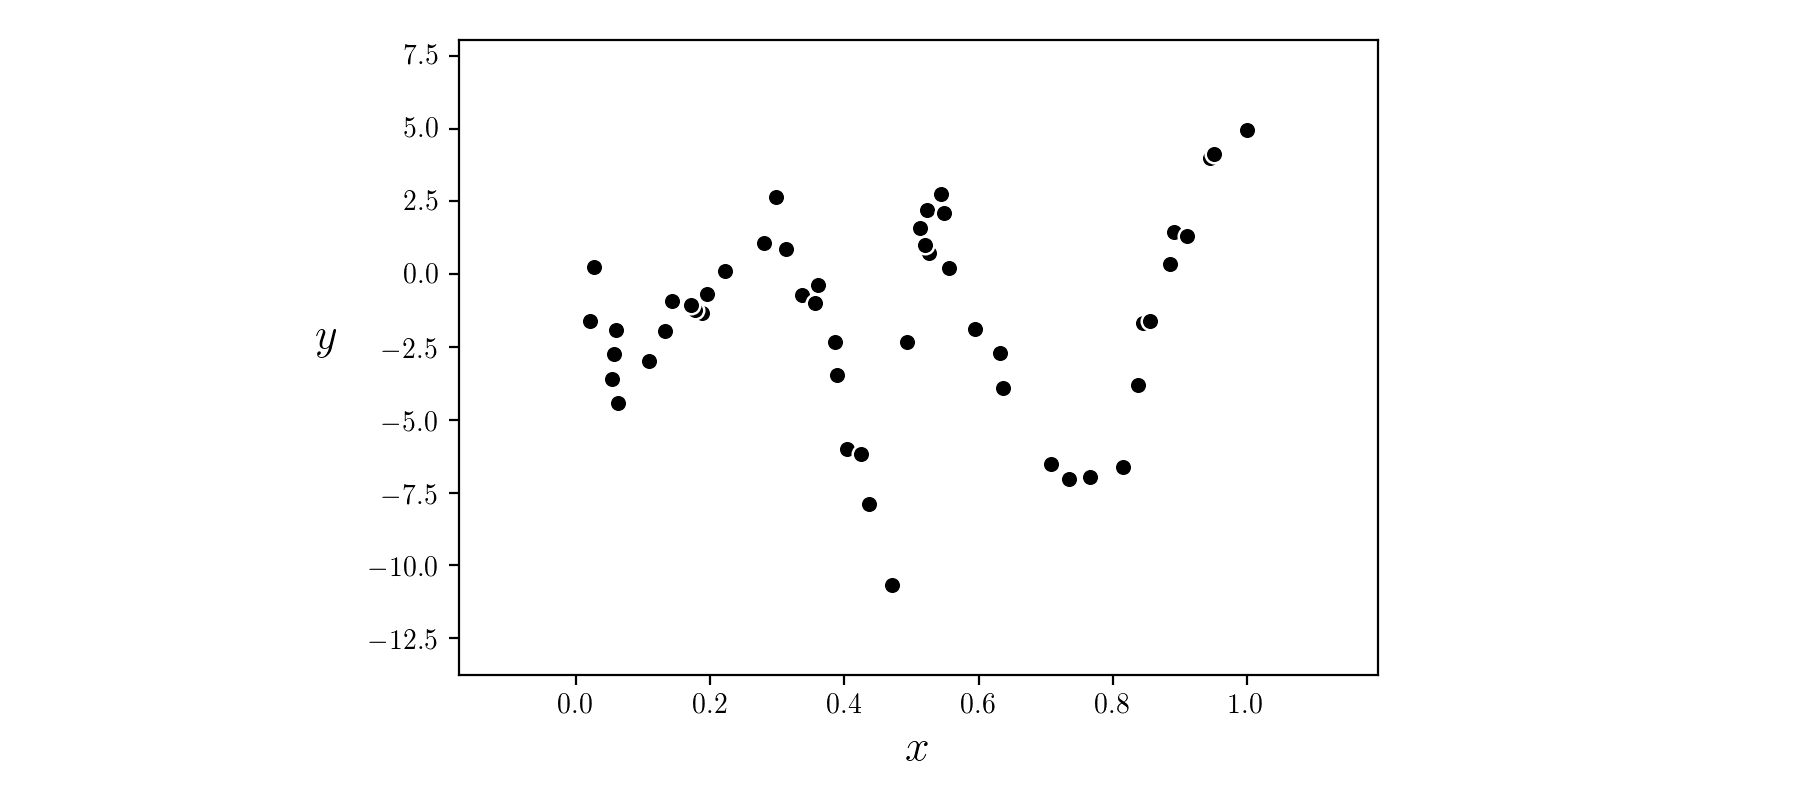

In [6]:
## This code cell will not be shown in the HTML version of this notebook
# load data
csvname = datapath + 'universal_regression_samples_0.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo1 = regress_plotter.Visualizer(data)
demo1.plot_data()

Here we use $U_1 = 100$ units, the `tanh` activation, and make a run of $5,000$ steps of gradient descent with $\alpha = 10^{-1}$ to fit all of model parameters.  Note that in order to initialize our model we need to create a list whose first entry contains the weights of our final linear combination, and whose second entry contains our array of internal weights - which we show below.

In [7]:
# define the number fo units to use
U_1 = 100     # number of single layer units to employ
N = 1         # dimension of input

# initialize internal weights of our single layer units
W_1 = 0.1*np.random.randn(N+1,U_1)

# initialize weights of our linear combination
w_2 = 0.1*np.random.randn(U_1+1,N)

# package weights together
w = [W_1,w_2]

With our run complete can then plot the resulting fit to the data, as shown below, which fits the data quite well. 

<IPython.core.display.Javascript object>


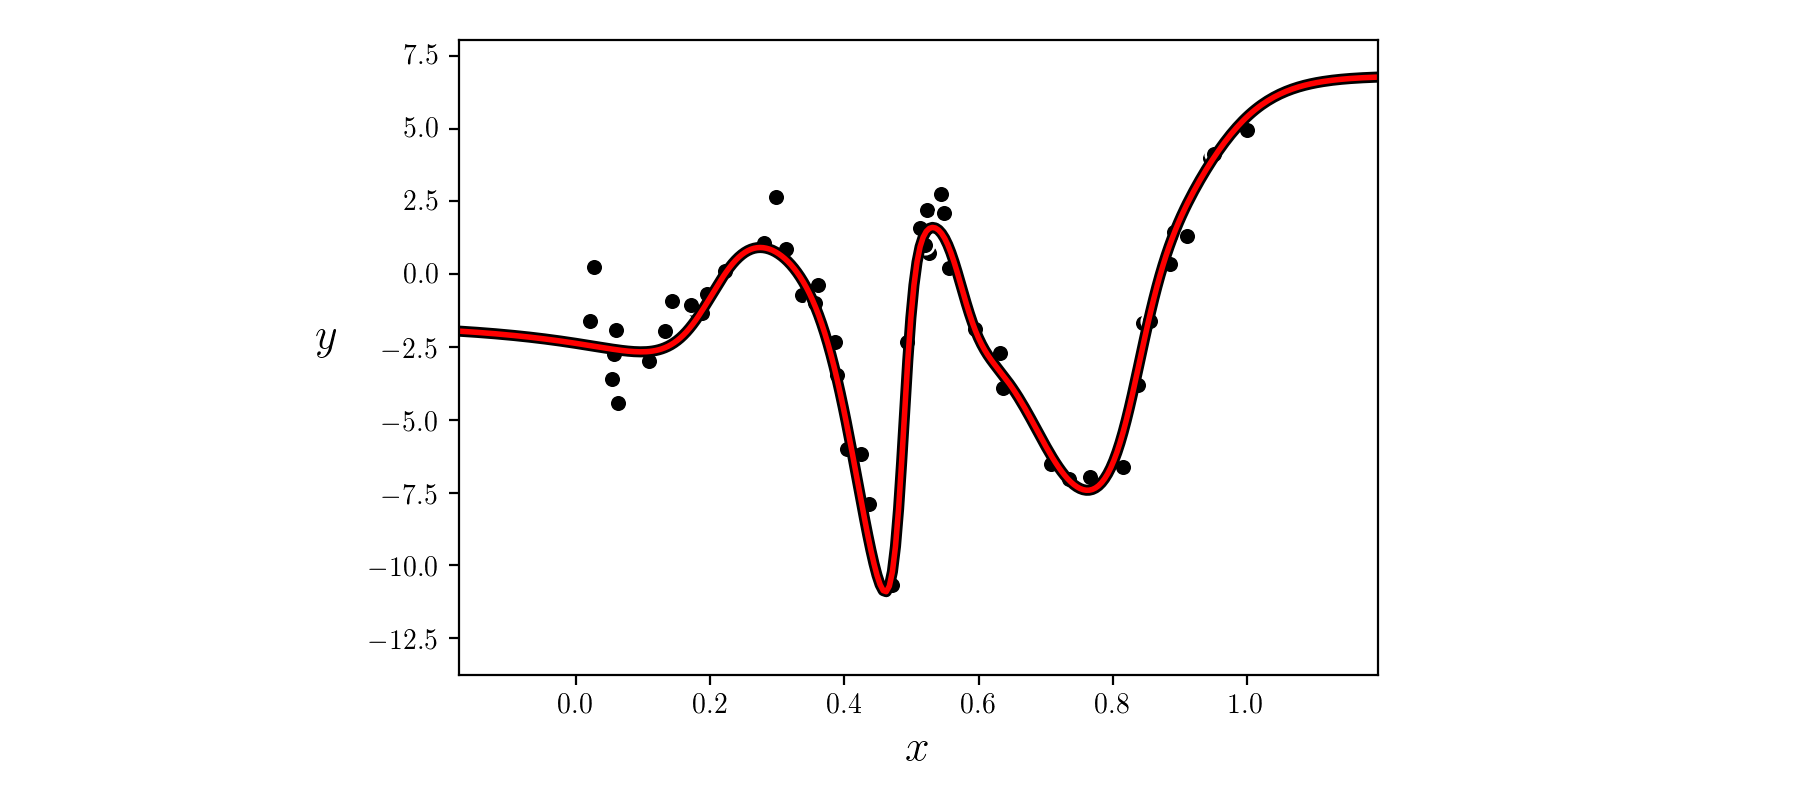

In [8]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib1 = multi.basic_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib1.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib1.make_train_val_split(train_portion = 1)

# choose cost
mylib1.choose_cost(name = 'least_squares')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [100]
mylib1.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh',scale = 0.1)

# fit an optimization
mylib1.fit(max_its = 5000,alpha_choice = 10**(-1),verbose = False)

# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(mylib1.train_cost_histories[0])
w_best = mylib1.weight_histories[0][ind]
demo1 = regress_plotter.Visualizer(data)
demo1.plot_fit(w_best,mylib1.model,normalizer = mylib1.normalizer);

#### <span style="color:#a50e3e;">Example 4. </span> Learning a nonlinear autoencoder using single layer units

In this example we learn a nonlinear manifold for the dataset shown below using an `encoder` and `decoder` models, each consisting of $U_1 = 10$ single layer `tanh` units.  To see how both encoding/decoding schemes mimic our `model` functionality see Section 12.4, where the notion of a nonlinear encoder was introduced.

<IPython.core.display.Javascript object>


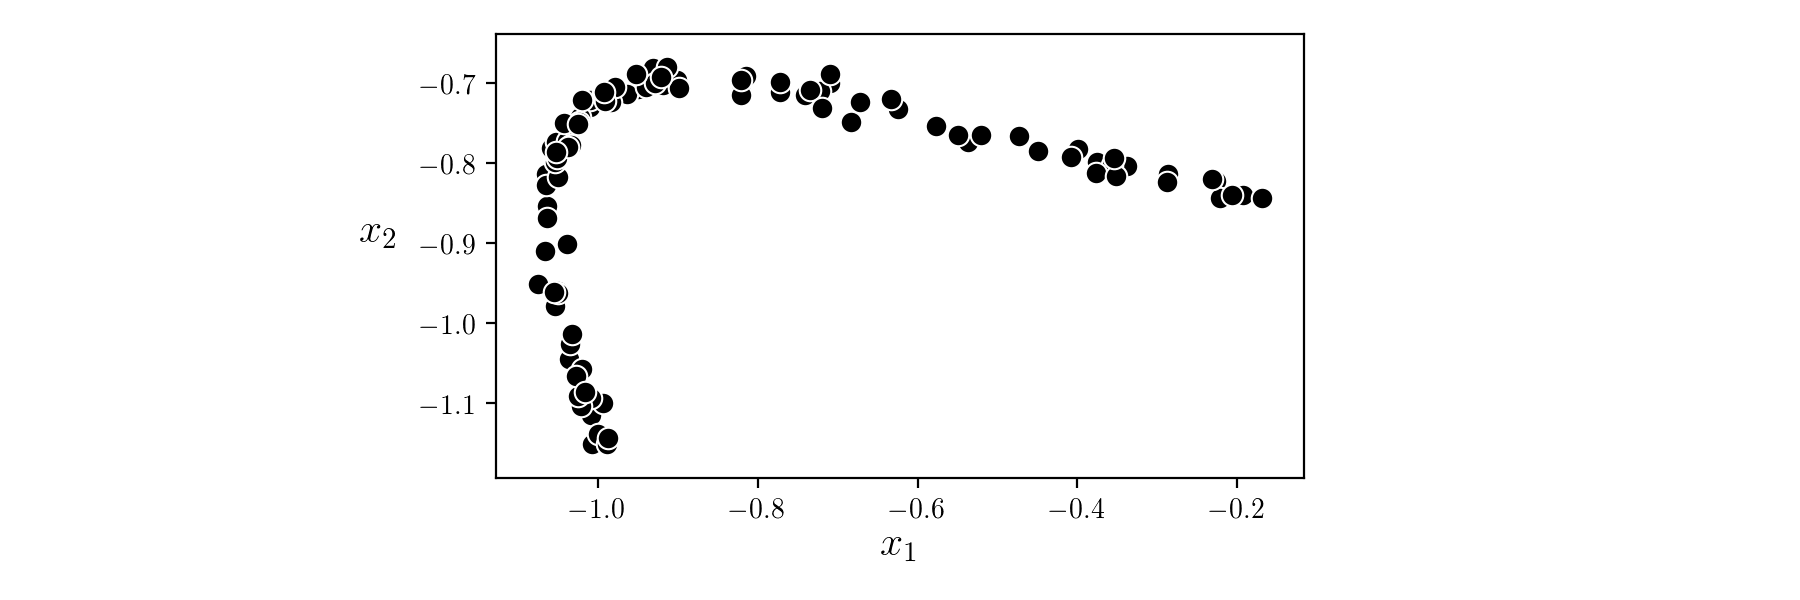

In [9]:
# This code cell will not be shown in the HTML version of this notebook
# import data
X = np.loadtxt(datapath + 'universal_autoencoder_samples_0.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,3))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0,labelpad = 15);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

Using our `feature_transforms` function for both encoding and decoding functions we make a run of  $1,000$ steps of gradient descent with $\alpha = 10^{-1}$ to fit all of autoencoder's parameters.  Note that in order to initialize our model we need to create a list whose first entry contains the weights of our final linear combination, and whose second entry contains our array of internal weights - for each of the encoding and decoding functions precisely as we did in the previous example.

With our run complete can then plot the resulting nonlinear manifold fit to the data, as shown below, which represents the data quite well.  In the bottom panel we illustrate how - once trained - the points in this space gravitate towards the learned autoencoder.

<IPython.core.display.Javascript object>


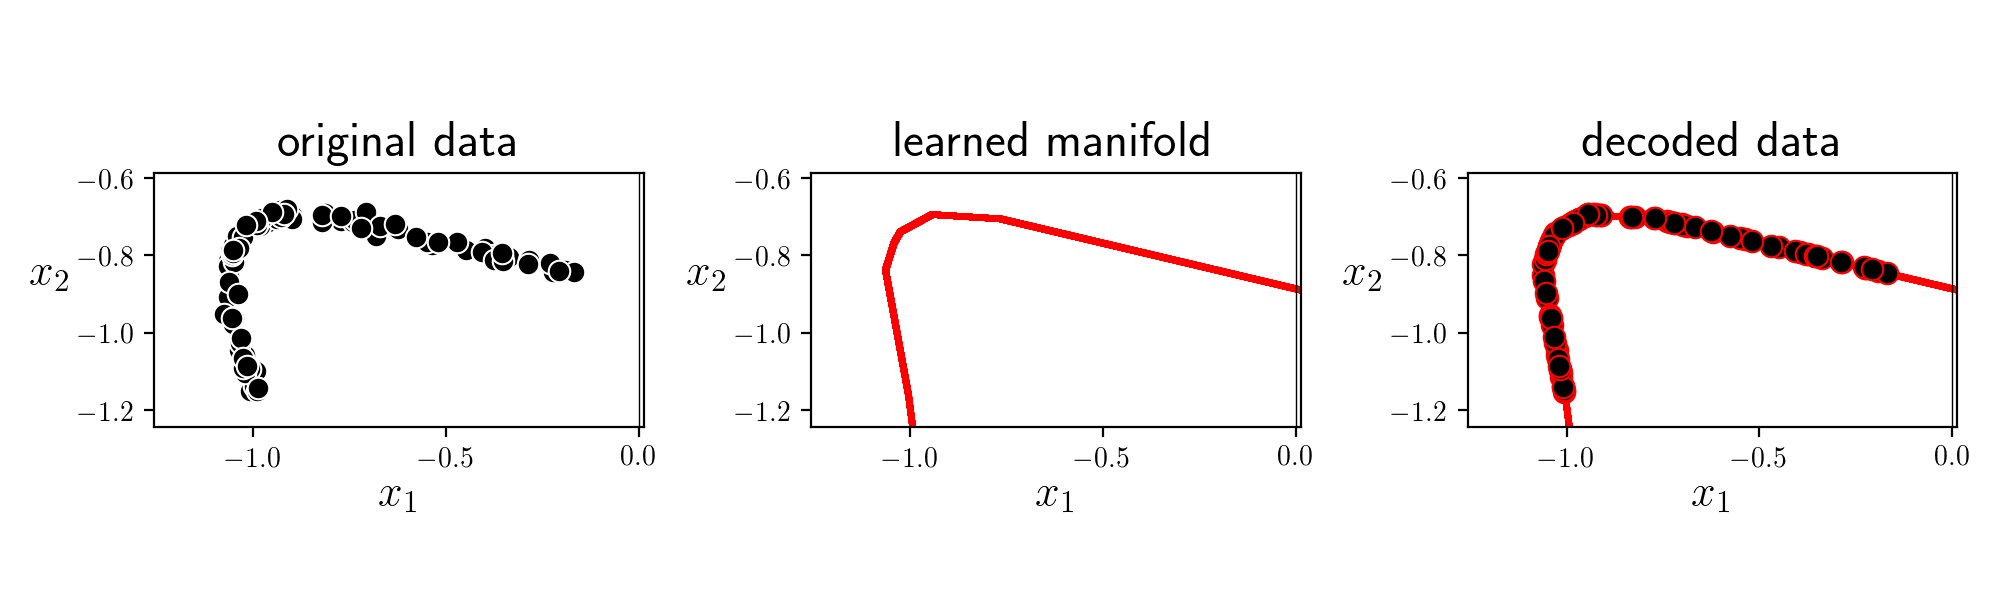

(2,)


<IPython.core.display.Javascript object>


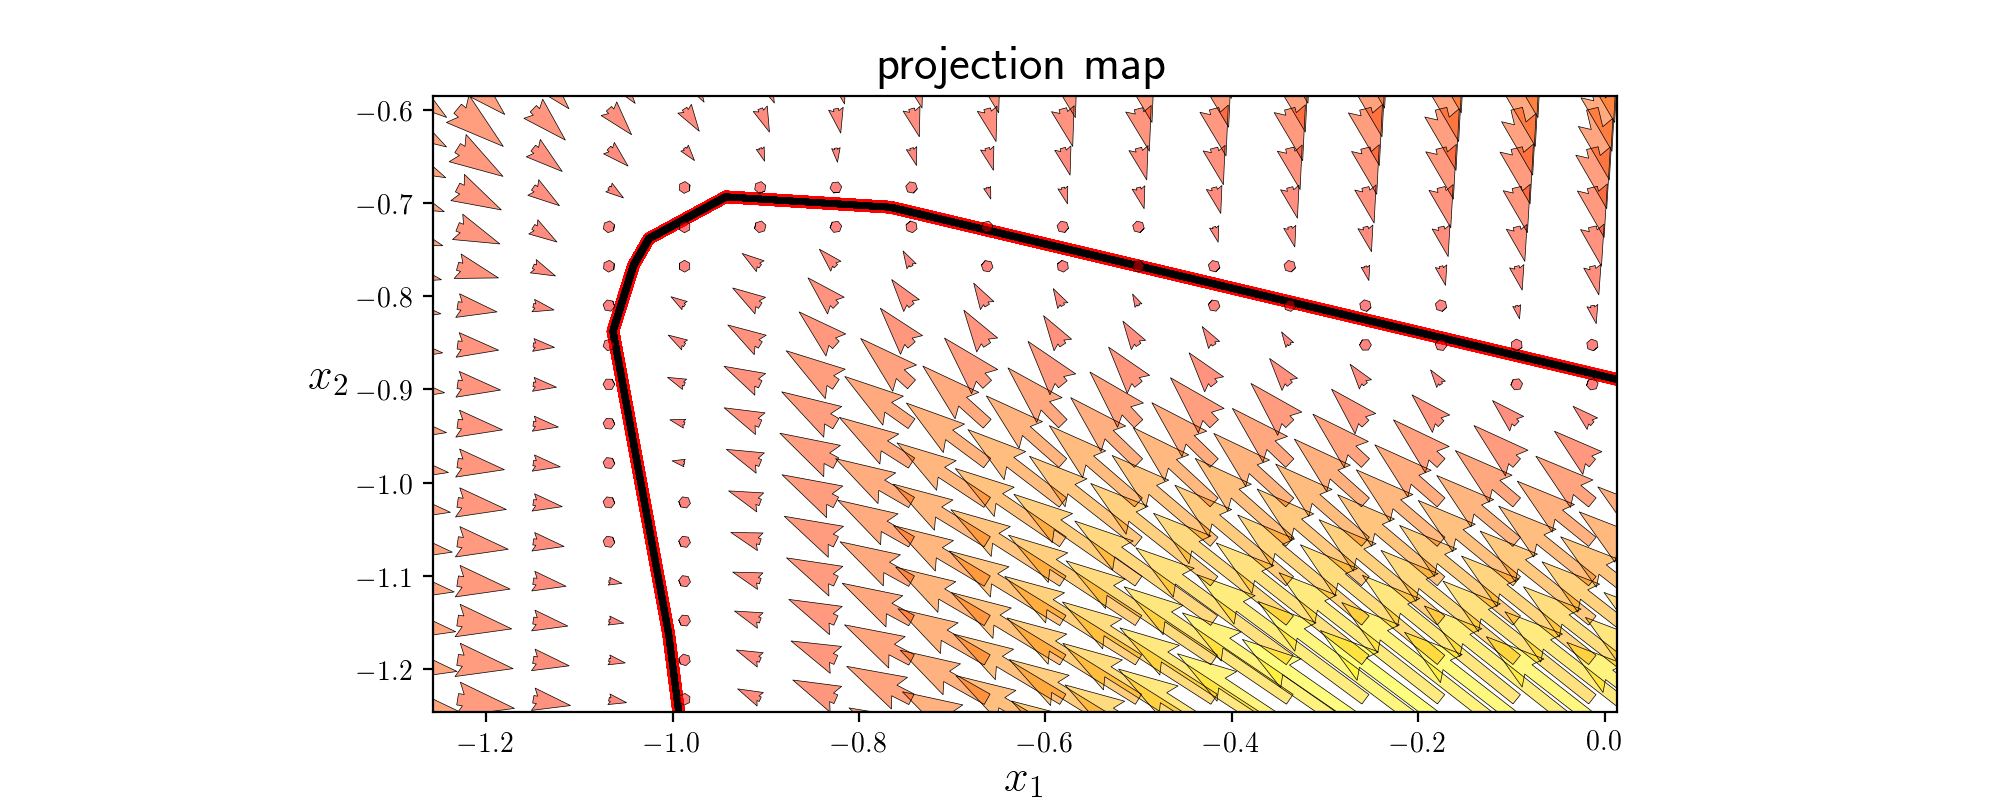

In [118]:
# This code cell will not be shown in the HTML version of this notebook
# create instance of library
mylib2 = multi.basic_lib.unsuper_setup.Setup(X)

# perform preprocessing step(s) - especially input normalization
mylib2.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib2.make_train_val_split(train_portion = 1)

# choose features
mylib2.choose_encoder(layer_sizes = [2,10,1],scale = 0.2)
mylib2.choose_decoder(layer_sizes = [1,10,2],scale = 0.2)

# choose cost
mylib2.choose_cost(name = 'autoencoder')

# fit an optimization
mylib2.fit(max_its = 1000,alpha_choice = 10**(-1),verbose = False)

# plot results
multi.autoencoder_demos.show_encode_decode(X,mylib2,projmap = True,scale = 10)

## 13.1.2 Two-layer units 

That single-layer units we discussed above have tunable internal parameters, giving them a range of possible shapes to take as saw in Examples 1 and 2. However, the flexibility of each unit is limited to some extent. In Example 1 all we can control is the horizontal placement of the function (via $w_{0}$) and the steepness of the transition from $-1$ to $1$ (via $w_{1}$). Similarly in Example 2, we can only move the ReLU in the horizontal direction and change the slope of its forearm. 

We boost the flexibility (or *capacity*) of these units by creating deeper *two layer* perceptrons, as we now describe.  These are also often referred to as two *hidden* layer perceptrons as well.

### Graphical and algebraic representation of two layer units

To create a two-layer perceptron unit we *recurse* on the idea of a single layer unit.  In short, to create a two layer unit we first construct a set of $U_1$ single layer units and treat them as we treated the input: that is we take their linear combination and pass the result through a nonlinear activation. This idea is illustrated graphically in Figure 4 below.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/two_layer_unit.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 4:</strong> <em> Graphical representation of a two-layer neural network unit. </em>
</figcaption>
</figure>

If we were to write out the algebraic form of a two-layer unit shown in the Figure above $f^{\left(2\right)}\left(\mathbf{x}\right)$ we have the formula  

\begin{equation}
f^{\left(2\right)}\left(\mathbf{x}\right)=a\left(w^{\left(2\right)}_{0}+\underset{i=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{i}}\,f^{(1)}_i\left(\mathbf{x}\right)\right)
\end{equation}

which reflects the recursive nature of the second layer unit algebraically.  As was the case with the single layer unit, this formula is perhaps easier to digest if we think about each step of the computation starting from the most internal (that is, the construction of the first layer units) to the final outer activation function.  We detail pulled-apart way of expressing the generic two layer unit algebraically in the 'recursive recipe' below. 

#### Recursive rescipe for two layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, number of single layer units $U_1$<br>

<strong>2:</strong>&nbsp;&nbsp;  Construct single layer units:  $\,\,\,\,\,\,\,\,\,f^{(1)}_i\left(\mathbf{x}\right)$ for $i=1,\,...,U_1$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\, v = w_{0}^{(2)}+{\sum_{i=1}^{U_1}}{w_{i}^{(2)}\,f^{(1)}_i}\left(\mathbf{x}\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\,\, a\left(v\right)$ <br>

<strong>5:</strong>&nbsp;&nbsp; <strong>output:</strong> Two layer unit $\,\, a\left(v\right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 5. </span> The shape of two-layer functions with $\text{tanh}$ activation

We plot four instances of a two-layer function using $\text{tanh}$ as activation, akin to what we did in Example 1. All weights are again set randomly in each instance.  These look like

\begin{equation}
f^{(2)}(x) = \text{tanh}\left(w_0^{(2)} + w_1^{(2)}\,f^{(1)}(x)\right)
\end{equation}

where

\begin{equation}
f^{(1)}(x) =  \text{tanh}\left(w_0^{(1)} + w_1^{(1)}x\right)
\end{equation}

Because this second layer unit has more internal parameters, consisting of linear combinations of single layer units, it is more flexible than the single layer units themselves.

In [ ]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 2, activation = 'tanh')

---

In general we will want to compute $B = U_2$ such two layer units - a number we define - as feature transformations in supervised / unsupervised learning `model` 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + f^{(2)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(2)}_{U_2}\left(\mathbf{x}\right)w_{U_2}
\end{equation}

as we described in the previous Chapter where we introduced the idea of nonlinear learning.  Notice in this case that each two layer unit now has its own unique internal parameters in the linear combination of single layer units (but the weights intnernal to the single layer units are the same for each two layer unit we define).  The $j^{th}$ of which looks like 

\begin{equation}
f^{\left(2\right)}_j\left(\mathbf{x}\right)=a\left(w^{\left(2\right)}_{0.j}+\underset{i=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{i,j}}\,f^{(1)}_i\left(\mathbf{x}\right)\right)
\end{equation}

These are our feature transformations, which we implement in a `feature_transforms` module (as done repeatedly in Chapter 12) as follows.

Figure 5 shows a graphical representation of these feature transformations along with their linear combination - a two-layer neural network model whose algebraic form is given in (16).

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/two_layer_unfolded.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 5:</strong> <em> Graphical representation of a two-layer neural network model, given in Equation (16), which is composed of $U_2$ two-layer feature transformations of the form shown in Equation (17).  </em>
</figcaption>
</figure>

### Effecient `Pythonic` implementation of two layer units

To construct an effecient `feature_transforms` function employing our two layer units we will use the same sort of compact notation - which carries over nicely in `Python` - used previously to implement single layer units in the previous Subsection.  There we commpactly represented our $U_1$ single layer units using the notation as

\begin{equation}
\text{single layer units} \,\,\,\,\,\,\,\,\, \mathbf{f}^{(1)} = \mathbf{a}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)
\end{equation}

(see the previous Subsection for a description of this notation).  Following the same pattern here to compactly express our second layer units, we first put all of the *internal* weights from $U_2$ functions.  Note how since the $j^{th}$ second layer unit's *input* are our $U_1$ first layer units, there are are $U_1 + 1$ internal weights: the bias $w^{\left(2\right)}_{0.j}$ and then input-touching weights $w^{\left(2\right)}_{1,j}$ through $w^{\left(2\right)}_{U_1,j}$.  Stacking these weights into the $j^{th}$ column of a matrix $\mathbf{W}_2$ then gives us a $\left(U_1 +1 \right)\times U_2$ matrix of all our units' internal weights 

\begin{equation}
\mathbf{W}_{2}=\left[\begin{array}{cccc}
w_{0,1}^{\left(2\right)} & w_{0,2}^{\left(2\right)} & \cdots & w_{0,U_{2}}^{\left(2\right)}\\
w_{1,1}^{\left(2\right)} & w_{1,2}^{\left(2\right)} & \cdots & w_{1,U_{2}}^{\left(2\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{U_1,1}^{\left(2\right)} & w_{U_1,2}^{\left(2\right)} & \cdots & w_{U_1,U_{2}}^{\left(2\right)}
\end{array}\right]
\end{equation}  

which mirrors precisely how we defined the $\left(N+1\right) \times U_1$ internal weight matrix $\mathbf{W}_1$ for our single layer units.

With this compact matrix notation we can then express all $U_2$ of our second layer units simulataneously in a single recursive vector-matrix computation 

\begin{equation}
\text{two layer units} \,\,\,\,\,\,\,\,\, \mathbf{f}^{(2)} = \mathbf{a}\left(\mathbf{W}_{2}^T\,\mathring{\mathbf{f}}^{(1)}\right)
\end{equation}

Notice - in comparing the formula above to the one given for the single layer units in equation (18) - how our recursive definition of the two layer units is beautifully reflected in this compact notation.  Also if we unwravel our notation our two layer units can also be written as $\mathbf{f}^{(2)} = \mathbf{a}\left(\mathbf{W}_2^T\mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)\right)$.  In either case, we do indeed have that the $j^{th}$ element of this computation is our $j^{th}$ second layer unit

\begin{equation}
\mathbf{f}^{(2)}_j = f^{\left(2\right)}_j\left(\mathbf{x}\right).
\end{equation}

Now we can construct our entire set of $U_2$ two layer perceptron units very efficiently (leveraging `Numpy`'s effecient matrix-vector product computation) as a `feature_transforms` function that takes in `x` - our input data - and the correctly sized matrix $\mathbf{W}_1$ for our first layer units and $\mathbf{W}_2$ for our second layer units - which we will input into the function as a list of matrices 

`w = [W_1,W_2]`.

Such a list of matrices or arrays is often called a *tensor*.  

In any case, below we provide an implementation based on the notation above for computing all of our $U_2$ second layer units effectively.  Notice how this two layer function matches structurally the single unit implementation given previously, but now we must loop over our *tensor* of matrices: on the first loop we compute all single layer units, and on the second we compute our second layer units.

In [ ]:
# a feature_transforms function for computing
# U_2 two layer perceptron units efficiently
def feature_transforms(x, w):    
    # assign new name to input x for recursive loop
    a = x 
    
    # loop through each layer matrix
    for W in w:
        # compute inner product with current layer weights
        a = W[0] + np.dot(a.T, W[1:])

        # output of layer activation
        a = activation(a).T
    return a

Before we look at a few examples, note that we can express our `model` using the sort of compact notation we employed in writing our set of two layer units so effectively.  Using a notation to denote the weights of the linear combination as

\begin{equation}
\mathbf{w}_{3} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_2}
\end{bmatrix}
\end{equation}

and extend our vector $\mathbf{f}^{(2)}$ by tacking a $1$ on top of it - which as usual we denote by adding a $\mathring{}$ symbol to the top of notation as $\mathring{\mathbf{f}}^{(2)}$ - we can then write out the model in equation (16) quite compactly as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathbf{w}_3^T\mathring{\mathbf{f}}^{(2)}
\end{equation}

where we use the notation $\mathbf{w}$ on the left hand side to denote all of the weights on the right - i.e., $\mathbf{w}_3$, $\mathbf{W}_2$, and $\mathbf{W}_1$.  

In the left panel of Figure 6 below we show a more compact representation of a two-layer network, employing the matrix notation defined in (19). Further using our condensed notation in the right panel we show its associated computational graph.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/two_layer_compact.png" width="90%" height="auto"/>
<figcaption> <strong>Figure 6:</strong> <em> (left) A condensed graphical representation of a  two-layer neural network. (right) This network can be represented more compactly via its computational graph. </em>
</figcaption>
</figure>

#### <span style="color:#a50e3e;">Example 6. </span> Nonlinear multiclass classification using two layer units

In this examople we will employ the two layer unit `feature_transforms` function above to perform nonlinear multiclass classification using the dataset shown below.

<IPython.core.display.Javascript object>


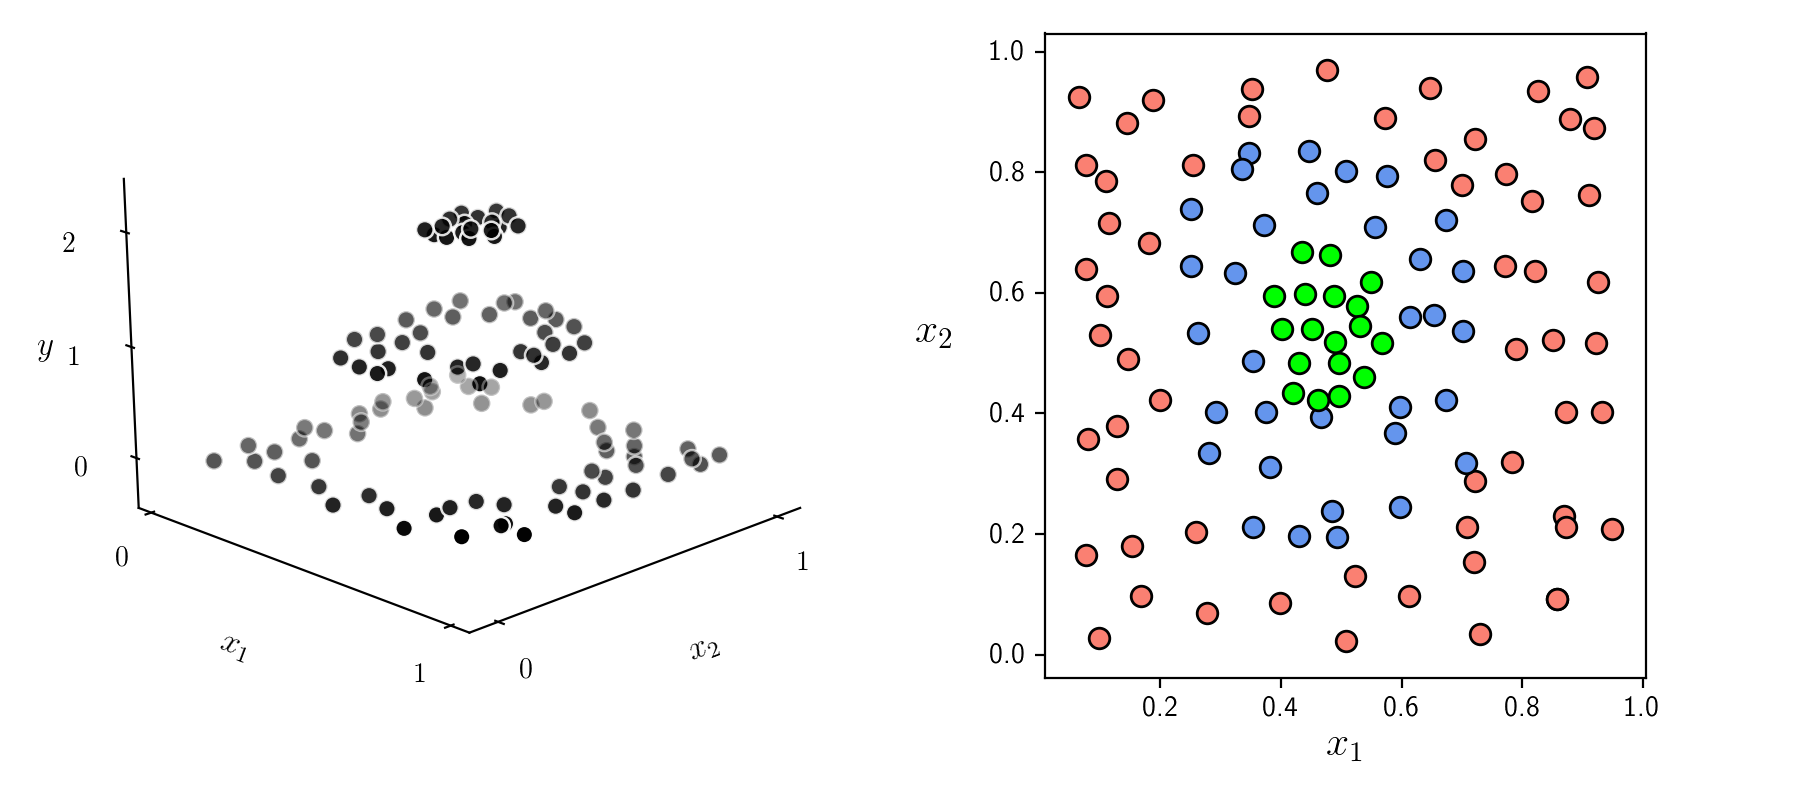

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# create an instance of a multiclass classification visualizer
demo3 = multi.nonlinear_classification_visualizer.Visualizer(datapath + '3_layercake_data.csv')
x = demo3.x.T
y = demo3.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo3.plot_data();

Here we chose the number of units $U_1$ and second units $U_2$ at random as $U_1 = 12$ and $U_2 = 5$.  Here we will use $10,000$ gradient descent steps to tune all of the parameters of our model: the weight matrices $\mathbf{W}_1$ and $\mathbf{W}_2$, along with our linear combination weights $\mathbf{w}_3$.  Below we show how to initialize the entire set of parameters for our `model`.  Notice here since we are performing $C=3$ class classification that - as discussed in Chapter 10 - we actually employing $3$ `models`, and so have $3$ sets of final linear combination weights.  We initialize and package them all together below by setting `w_3 = 0.1*np.random.randn(U_2+1,3)`.

In [ ]:
# define the number fo units to use in each layer
N = 2         # dimension of input
U_1 = 12      # number of single layer units to employ
U_2 = 5       # number of two layer units to employ

# initialize internal weights of our single layer units
W_1 = 0.1*np.random.randn(N+1,U_1)

# initialize internal weights of our second layer units
W_2 = 0.1*np.random.randn(U_1+1,U_2)

# initialize weights of our linear combination
w_3 = 0.1*np.random.randn(U_2+1,3)

# package all weights together in a single list
w = [W_1,W_2,w_3]

Now we make our run of gradient descent, taking $10,000$ steps with $\alpha = 10^{-1}$, to minimize the multiclass softmax cost employing our `feature_transforms` function and the initialization above.  We plot out the cost / accuracy history from this run below to verify that our models have been well tuned.  As can be seen below, after a few thousand iterations we achieve perfect classification results.

<IPython.core.display.Javascript object>


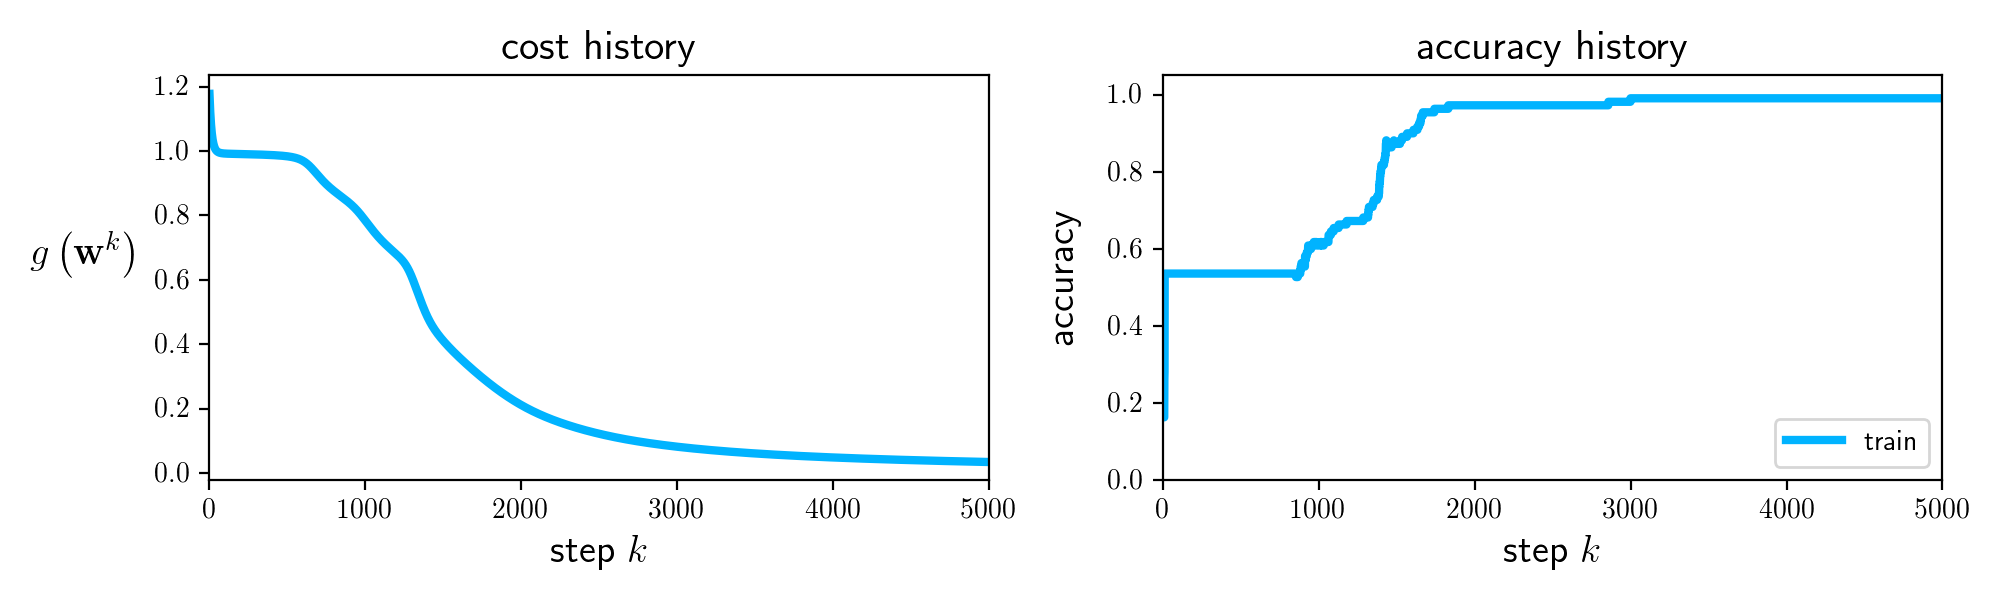

In [144]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib3 = multi.basic_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib3.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib3.make_train_val_split(train_portion = 1)

# choose cost
mylib3.choose_cost(name = 'multiclass_softmax')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [12,5]
mylib3.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh',scale = 0.1)

# fit an optimization
mylib3.fit(max_its = 5000,alpha_choice = 10**(-1),verbose = False)

# plot cost function history
mylib3.show_histories()

Now we plot the resulting fit, visualizing the surface fit and - simultaneously - the nonilnear boundary from our best set of weights below.

<IPython.core.display.Javascript object>


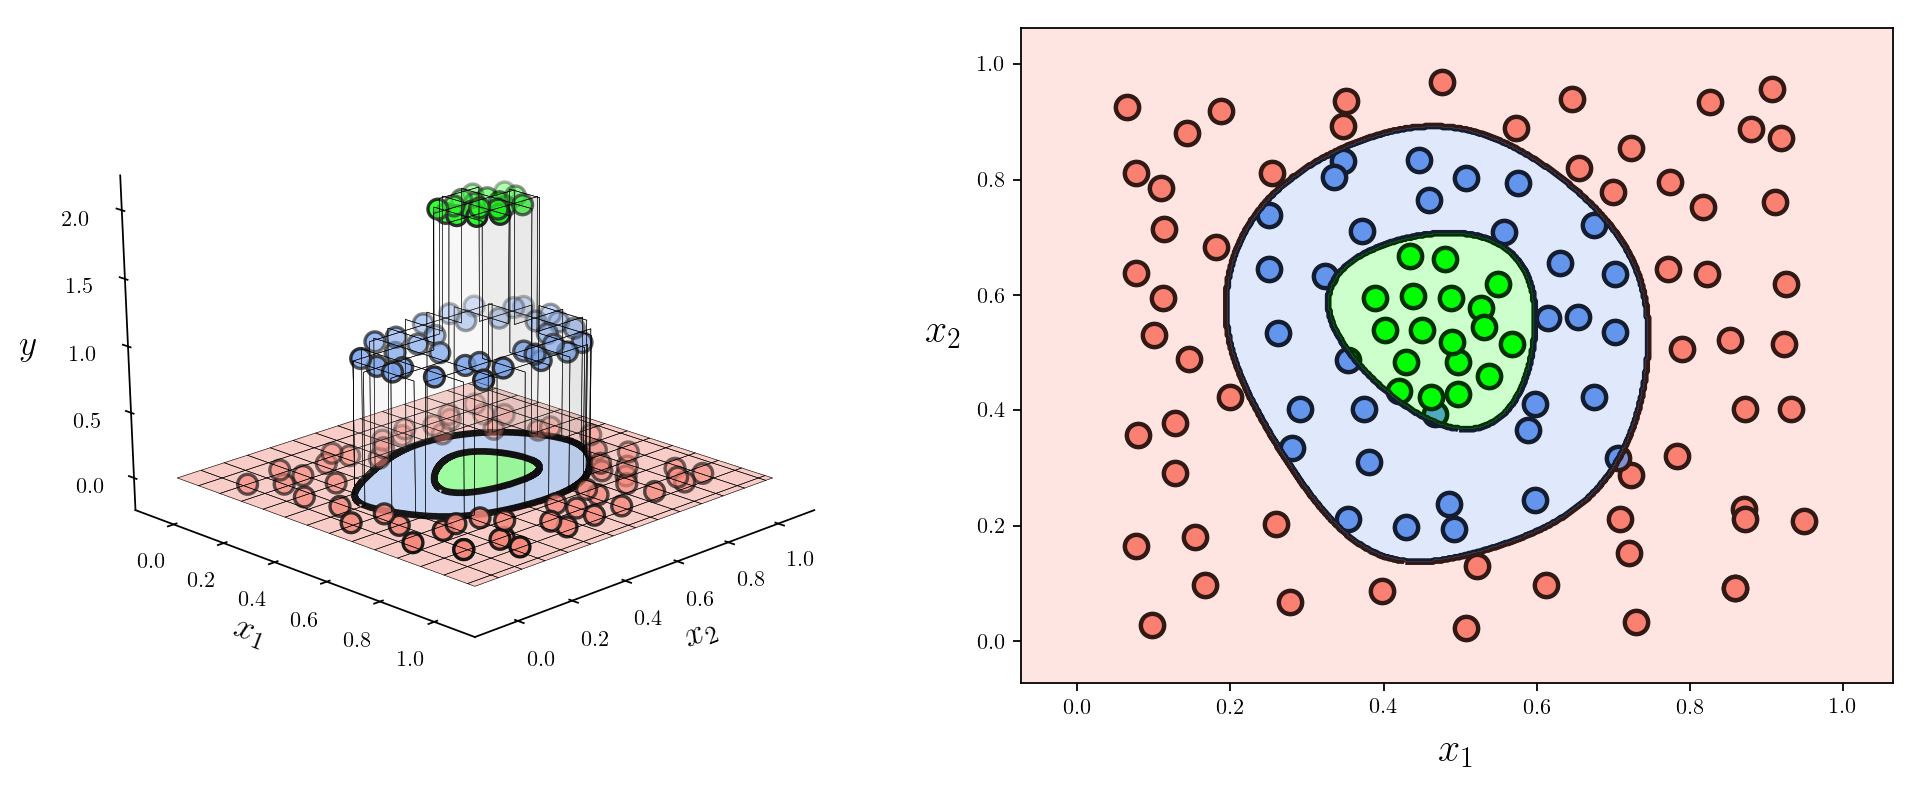

In [128]:
# This code cell will not be shown in the HTML version of this notebook
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmax(mylib3.train_accuracy_histories[0])
w_best = mylib3.weight_histories[0][ind]

# plot result of nonlinear multiclass classification
demo3.multiclass_plot(mylib3,w_best)

## 13.1.3 General multilayer units

By recursing on the pattern we have seen above in describing single and two layer perceptron units we can construct arbitrary *multilayer perceptron units*, likeiwse called *deep networks*.  Here we extend the discussion above in order to achieve this generality, constructing $L$ layer multilayer perceptrons.

### Graphical and algebraic representation of general $L$-layer units

In Figure 7 below we show the graphical representation of a general $L$ layer multilayer perceptron unit. To construct a perceptron like this with an arbitrary number of layers we simply recurse on the pattern we have seen established for single- and two-layer units above.  In other words, to construct such a unit we take a linear combination of $L-1$ layer units and pass the result through an activation.

If we were to write out the algebraic form of an $L$ layer unit shown in the Figure above $f^{\left(L\right)}\left(\mathbf{x}\right)$ we have the formula  

\begin{equation}
f^{\left(L\right)}\left(\mathbf{x}\right)=a\left(w^{\left(L\right)}_{0}+\underset{i=1}{\overset{U_{L-1}}{\sum}}{w^{\left(L\right)}_{i}}\,f^{(L-1)}_i\left(\mathbf{x}\right)\right).
\end{equation}

which reflects the recursive nature of the $L$ layer unit algebraically.  As was the case with the two layer unit, this formula is perhaps easier to digest if we think about each step of the computation starting from the most internal (that is, the construction of the first layer units) to the final outer activation function.  We detail pulled-apart way of expressing the generic two layer unit algebraically in the 'recursive recipe' below. 

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/L_layer_unit.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 7:</strong> <em> Graphical representation of an $L$-layer neural network unit. </em>
</figcaption>
</figure>

#### Recursive rescipe for $L$ layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, number of single layer units $U_1$<br>

<strong>2:</strong>&nbsp;&nbsp;  Construct $L-1$ layer units:  $\,\,\,\,\,\,\,\,\,f^{(L-1)}_i\left(\mathbf{x}\right)$ for $i=1,\,...,U_{L-1}$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\, v = w_{0}^{(L)}+{\sum_{i=1}^{U_{L-1}}}{w_{i}^{(L)}\,f^{(L-1)}_i}\left(\mathbf{x}\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\,\, a\left(v\right)$ <br>

<strong>5:</strong>&nbsp;&nbsp; <strong>output:</strong> $L$ layer unit $\,\, a\left(v\right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 7. </span> The shape of three-layer functions with $\text{tanh}$ activation 

In this Example we show four instances of a three-layer perceptron unit with $\text{tanh}$ activation.  In each instance all weights are set randomly. Because each unit here consists of a composition of three nonlinear functions, and because it has a great many parameters, these three-layer instances are considerably more flexible than the two-layer versions we saw previously.

In particular here we show off instances of a three layer unit, where each prior layer has a single unit each.  We could express these algebraically as 

\begin{equation}
f^{(3)}(x) = \text{tanh}\left(w_0^{(3)} + w_1^{(3)}\,f^{(2)}(x)\right)
\end{equation}

where

\begin{array}
\
f^{(2)}(x) = \text{tanh}\left(w_0^{(2)} + w_1^{(2)}\,f^{(1)}(x)\right) \\
f^{(1)}(x) =  \text{tanh}\left(w_0^{(1)} + w_1^{(1)}x\right)
\end{array}

<IPython.core.display.Javascript object>


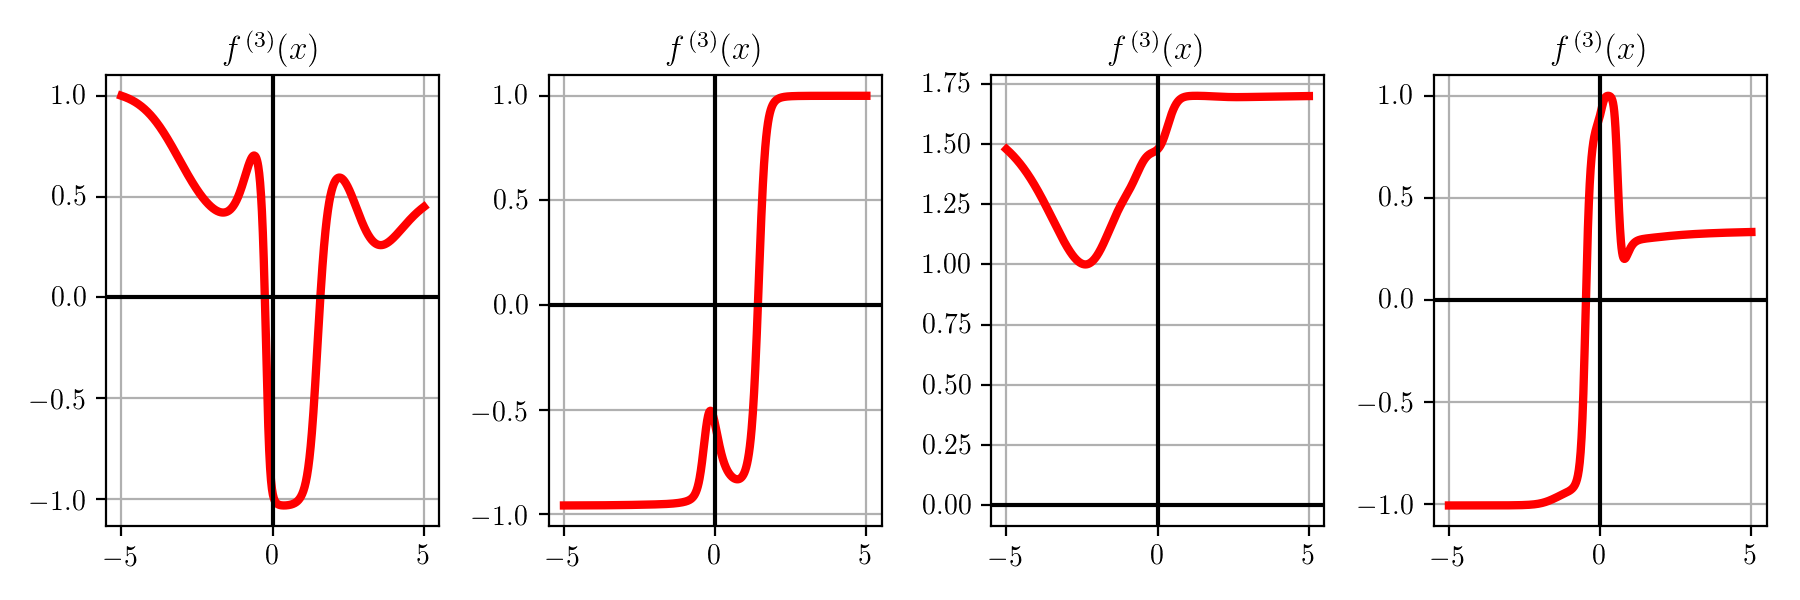

In [147]:
# This code cell will not be shown in the HTML version of this notebook
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 3, activation = 'tanh')

---

In general we will want to compute $B = U_L$ such $L$ layer units - a number we define - as feature transformations in supervised / unsupervised learning `model` 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + f^{(L)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(L)}_{U_L}\left(\mathbf{x}\right)w_{U_L}
\end{equation}

as we described in the previous Chapter where we introduced the idea of nonlinear learning.  The $j^{th}$ of which looks like 

\begin{equation}
f^{\left(L\right)}_j\left(\mathbf{x}\right)=a\left(w^{\left(L\right)}_{0.j}+\underset{i=1}{\overset{U_{L-1}}{\sum}}{w^{\left(L\right)}_{i,j}}\,f^{(L-1)}_i\left(\mathbf{x}\right)\right)
\end{equation}

These are our feature transformations, which we implement in a `feature_transforms` module (as done repeatedly in Chapter 12) as follows.

Figure 8 shows a graphical representation of these feature transformations along with their linear combination - an $L$-layer neural network model whose algebraic form is given in (26).

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/L_layer_unfolded.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 8:</strong> <em> Graphical representation of an $L$-layer neural network model, given in Equation (26), which is composed of $U_L$ $L$-layer feature transformations of the form shown in Equation (27).  </em>
</figcaption>
</figure>

### Effecient `Pythonic` implementation of $L$ layer units

To construct an effecient `feature_transforms` function we follow precisely the same steps we used in developing the single and two layer versions above.  First note that our $L-1$ layer units can be expressed (using the notation introduced in the previous two Subsection) compactly as a generalization of equation (20) 

\begin{equation}
\text{(L-1) layer units} \,\,\,\,\,\,\,\,\, \mathbf{f}^{(L-1)} = \mathbf{a}\left(\mathbf{W}_{L-2}^T\,\mathring{\mathbf{f}}^{(L-2)}\right).
\end{equation}

We then construct a weight matrix $\mathbf{W}_L$ to contain all of the internal weights of our $L^{th}$ layer units by stacking our $j^{th}$ unit's weights into the $j^{th}$ column as

\begin{equation}
\mathbf{W}_{L}=\left[\begin{array}{cccc}
w_{0,1}^{\left(L\right)} & w_{0,2}^{\left(L\right)} & \cdots & w_{0,U_{L}}^{\left(L\right)}\\
w_{1,1}^{\left(L\right)} & w_{1,2}^{\left(L\right)} & \cdots & w_{1,U_{L}}^{\left(L\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{U_{L-1},1}^{\left(L\right)} & w_{U_{L-1},2}^{\left(L\right)} & \cdots & w_{U_{L-1},U_{L}}^{\left(L\right)}
\end{array}\right]
\end{equation}  

Note that this matrix has dimensions $\left(U_{L-1} +1 \right)\times U_L$.  With this compact matrix notation we can then express all $U_L$ of our $L$ layer units simulataneously in a single recursive vector-matrix computation 

\begin{equation}
\text{L layer units} \,\,\,\,\,\,\,\,\, \mathbf{f}^{(L)} = \mathbf{a}\left(\mathbf{W}_{L}^T\,\mathring{\mathbf{f}}^{(L-1)}\right)
\end{equation}

If we unwravel our notation our $L$ units can also be written as

\begin{equation}
\mathbf{f}^{(L)} = \mathbf{a}\left(\mathbf{W}_{L}^T\mathring{\mathbf{a}}\left(\mathbf{W}_{L-1}^T\,\mathring{\mathbf{a}}\left( \cdots \mathbf{W}_{1}^T\mathring{\mathbf{x}}\right) \right)\right)\cdots ).
\end{equation}

In either case, we do indeed have that the $j^{th}$ element of this computation is our $j^{th}$ second layer unit

\begin{equation}
\mathbf{f}^{(L)}_j = f^{\left(L\right)}_j\left(\mathbf{x}\right).
\end{equation}

Now we can construct our entire set of $U_L$ $L$ layer perceptron units very efficiently as a `feature_transforms` function that takes in `x` which we will call `a` - our input data - and the correctly sized matrices $\mathbf{W}_1$ through $\mathbf{W}_L$ for each layer of our perceptron.  This will result in a long list of matrices

`w = [W_1,W_2,W_3,...,W_L]`

also known as a *tensor*.  

In any case, below we provide an implementation based on the notation above for computing all of our $U_L$ second layer units effectively.  Notice how this is precisely the code block we wrote for the two layer case above, only now we loop over $L$ weight matrices instead of just two.

In [ ]:
# a feature_transforms function for computing
# U_L L layer perceptron units efficiently
def feature_transforms(a, w):    
    # loop through each layer matrix
    for W in w:
        # compute inner product with current layer weights
        a = W[0] + np.dot(a.T, W[1:])

        # output of layer activation
        a = activation(a).T
    return a

Before we look at a few examples, note that we can express our `model` using the sort of compact notation we employed in writing our set of two layer units so effectively.  Using a notation to denote the weights of the linear combination as

\begin{equation}
\mathbf{w}_{L+1} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_L}
\end{bmatrix}
\end{equation}

and extend our vector $\mathbf{f}^{(L)}$ by tacking a $1$ on top of it - which as usual we denote by adding a $\mathring{}$ symbol to the top of notation as $\mathring{\mathbf{{f}}}^{(L)}$ - we can then write out the model in equation (16) quite compactly as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathbf{w}_{L+1}^T\mathring{\mathbf{{f}}}^{(L)}
\end{equation}

where we use the notation $\mathbf{w}$ on the left hand side to denote all of the weights on the right - i.e., $\mathbf{w}_{L+1}$ and all weight matrices $\mathbf{W}_1$ through $\mathbf{W}_L$.

In Figure 9 we show a graphical representation of an $L$-layer network (top panel) along with its computational graph (bottom panel) employing once again our condensed notation described above.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/L_layer_compact.png" width="60%" height="auto"/>
<figcaption> <strong>Figure 9:</strong> <em> Graphical representation of an $L$-layer neural network (top) along with its computational graph (bottom). </em>
</figcaption>
</figure>

Below we also provide a ``Python`` function ``initialize_network_weights`` that creates initial weights for a feedforward network, and also provides a simple interface for generating feedforward architectures with arbitrary numbers of layers.  To create a desired network you simply input a **comma-separated list** called ``layer_sizes`` into the function of the following form

\begin{equation}
\text{layer_sizes} = \begin{bmatrix}
N = \text{dimension of input }\mathbf{x} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \\
U_1 = \text{number of desired units in layer 1} \\
U_2 = \text{number of desired units in layer 2} \\
\vdots \\
U_L = \text{number of desired units in layer L} \\
M = \text{dimension of output } y \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\end{bmatrix}
\end{equation}

The initializer will then automatically create initial weight matrices (of the proper dimensions) $\mathbf{W}_1$ through $\mathbf{W}_L$ as well as the final weights for the linear combination in the prediction $\mathbf{w}$.  We will see explicit examples using this functionality - as well as the previous ``Python`` functions - in the examples below.

In [ ]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes, scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k+1,U_k_plus_1)
        weights.append(weight)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

#### <span style="color:#a50e3e;">Example 8. </span> The shape of random autoencoder functions employing a 5 layer multilayer perceptron for both encoder and decoder 

In Section 12.3 we introduced the general nonlinear autoencoder, which consists of two (in general) nonlinear functions - an `encoder` $f_{\text{e}}$ and `decoder` $f_{\text{d}}$ - whose parameters we tune so that (ideally) the composition $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ forms the best *nonlinear manifold* on which the input data sits.  That is, given a set of input points $\left\{\mathbf{x}_p\right\}_{p=1}^P$ we aim tune the parameters of our encoder / decoder pair so that ideally

\begin{equation}
f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) \approx \mathbf{x}_p
\end{equation}
 
for all of the datapoints.  Just as with a supervised learner we can use a multilayer perceptron here - and for both encoding and decoding functions - which in combination provides us with an enormous amount of flexibility in terms of the sort of nonlinear manifolds we can uncover.  

Below we plot out 9 random instances of an antoencoder function $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ where we have used a 5 hidden layer multilayer perceptron with 10 units in each layer for both functions, and the function `sinc` as an activation.  In other words, below is plotted 9 instances of the function $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ where both $f_{\text{d}}$ and $f_{\text{e}}$ are 5 layer networks with randomly chosen weights in each instance.  Each of examples shows the kind of nonlinear manifold we could potentially discover using such encoding/decoding functions.

<IPython.core.display.Javascript object>


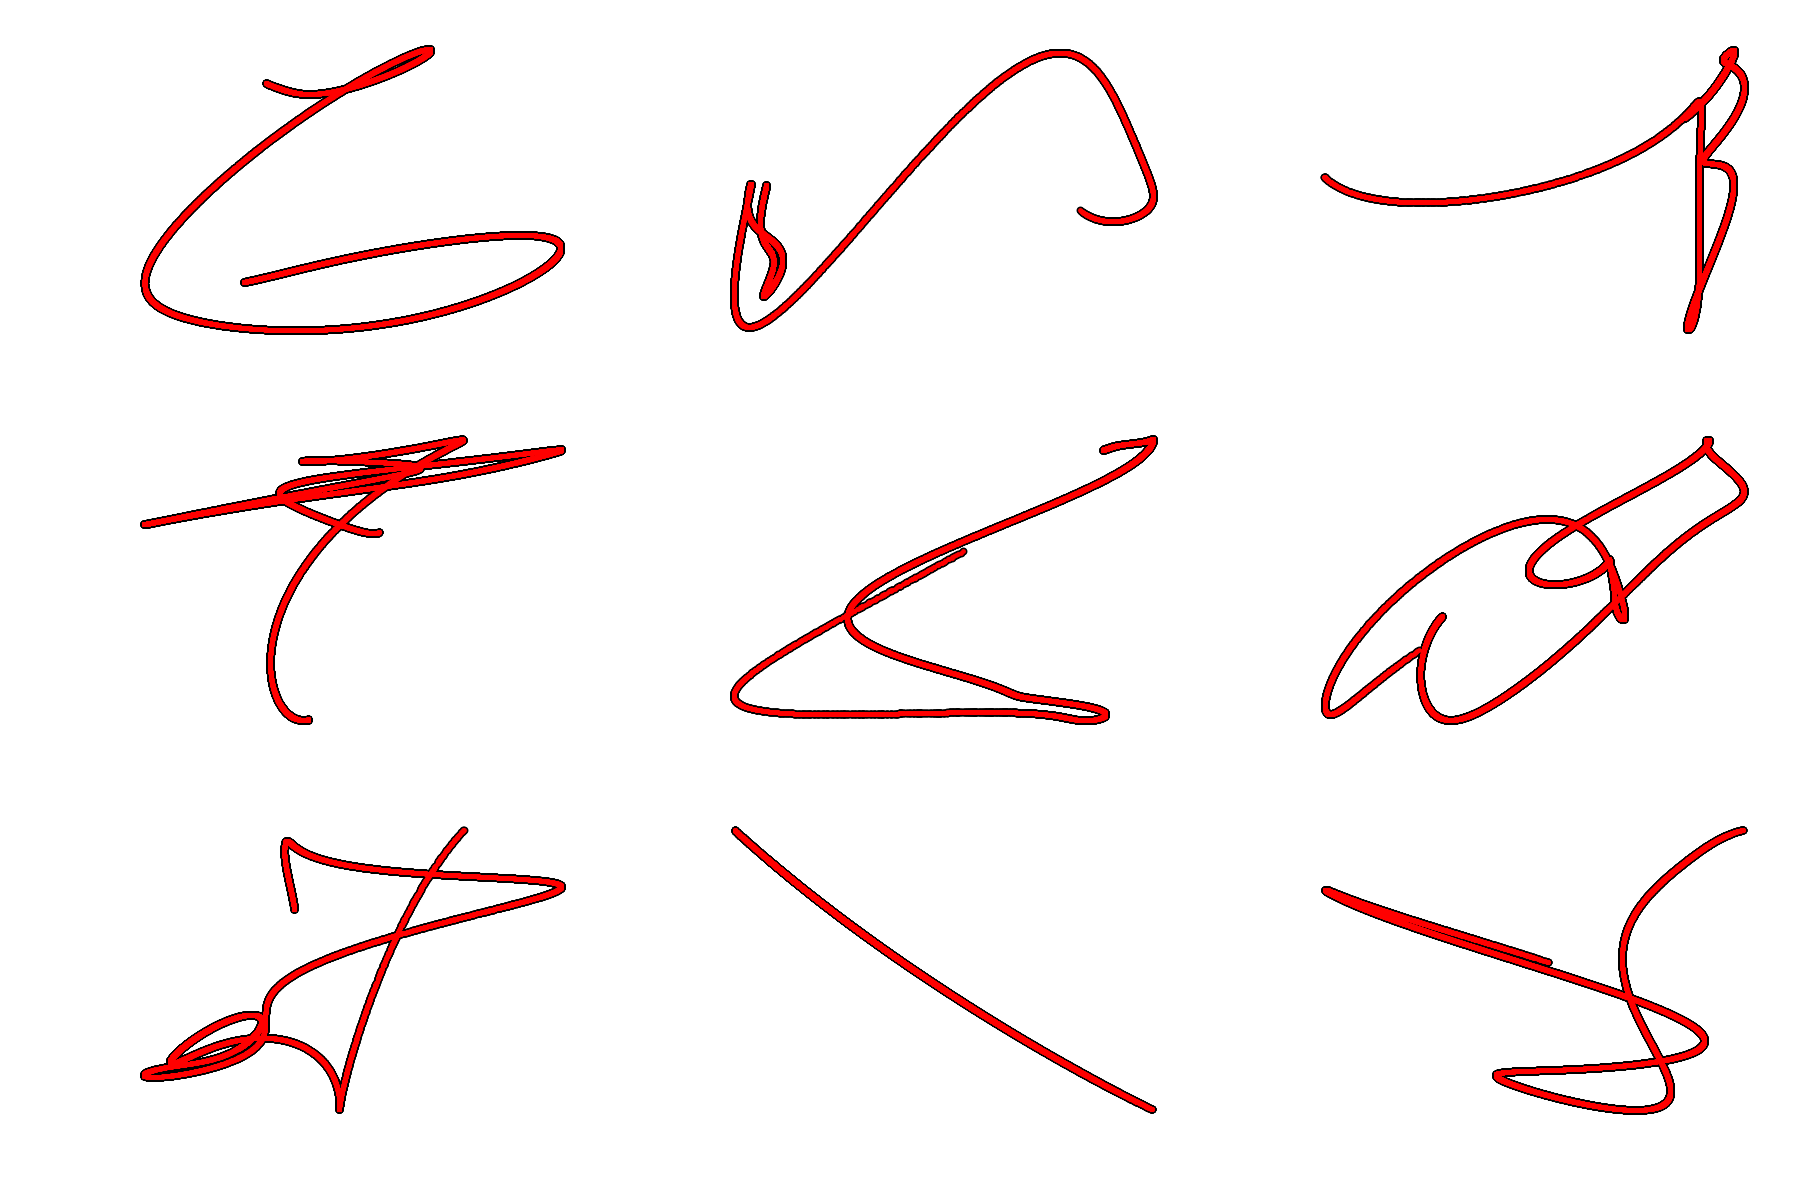

In [148]:
# This code cell will not be shown in the HTML version of this notebook
# show off 9 random autoencoders built using a 5 layer network for both
# encoder and decoder function and sinc as an activation function
demo = nonlib.squiggle_generator.Setup()
demo.make_so_many_squiggles()

#### <span style="color:#a50e3e;">Example 9. </span>  Nonlinear regression using multilayer perceptrons

In this example we demonstrate the usage of the ``Python`` functionality below to create an arbitrary feedforward network architecture to perform nonlinear regression using the toy dataset below.

<IPython.core.display.Javascript object>


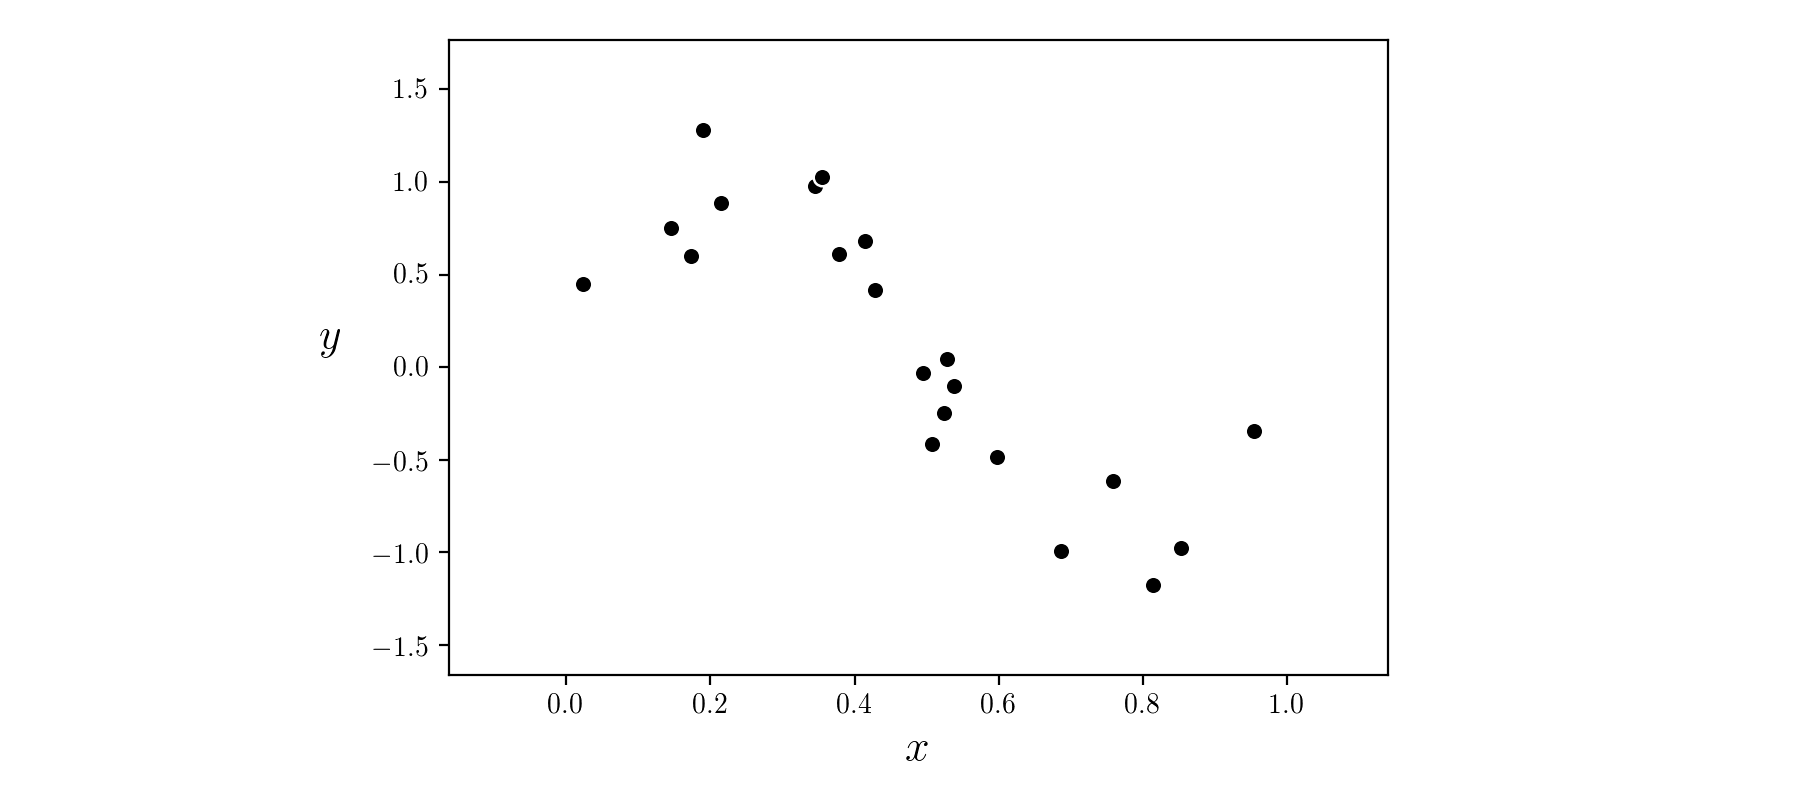

In [157]:
# This code cell will not be shown in the HTML version of this notebook
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo4 = regress_plotter.Visualizer(data)
demo4.plot_data()

Here we will use a 3 layer network with 10 units in each layer (we chose the number of units in each layer arbitrarily here).  This will certainly overfit the dataset if we tune the parameters well!

In the next Python cell we create the handle list ``layer_sizes`` for our network and generate the initial weights.

In [ ]:
# An example 4 hidden layer network, with 10 units in each layer
N = 1  # dimension of input
M = 1  # dimension of output
U_1 = 10; U_2 = 10; U_3 = 10; U_4 = 10;  # number of units per hidden layer

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,U_4,M]

# generate initial weights for our network
w = initialize_network_weights(layer_sizes, scale = 0.5)

With all of our weights initialized we can then use gradient descent to tune them properly (here we used the normalized version).  Below we define our ``least_squares`` cost function and run normalized gradient descent for 5000 iterations using a fixed steplength parameter $\alpha = 10^{-1}$.  We can then examine the cost function history to make sure gradient descent is converging properly.

<IPython.core.display.Javascript object>


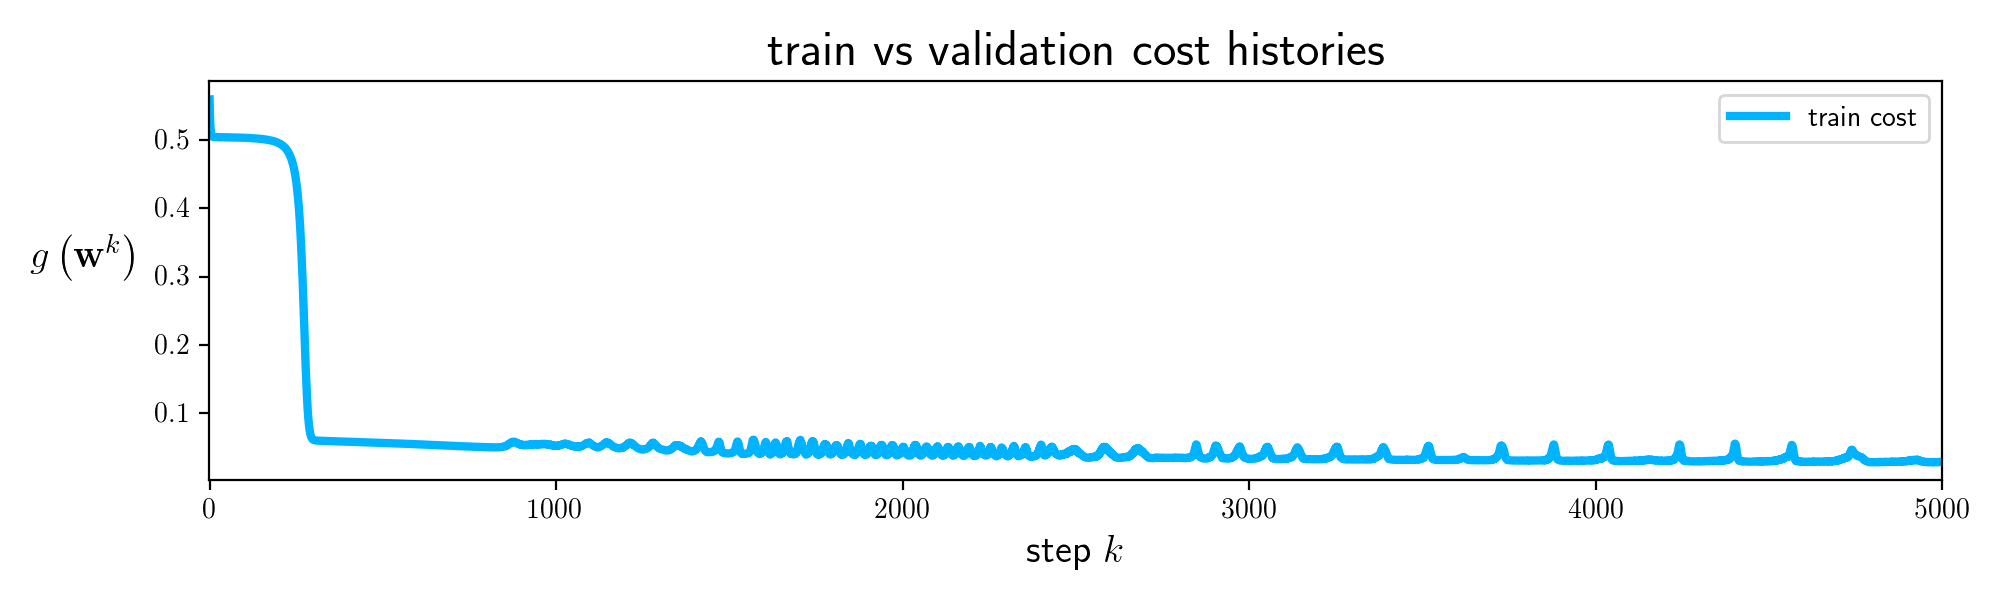

In [169]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib4 = multi.basic_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib4.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib4.make_train_val_split(train_portion = 1)

# choose cost
mylib4.choose_cost(name = 'least_squares')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10,10,10,10]
mylib4.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'relu',scale = 0.1)

# fit an optimization
mylib4.fit(max_its = 5000,alpha_choice = 10**(-1),verbose = False)

# plot cost function history
mylib4.show_histories()

The cost function plot looks good!  Taking the final weight from our history we can then evaluate testing points through our ``model`` function.  In particular we can illustrate our nonlinear prediction - which we do below.  We certainly do overfit, but this is not a surprise since our network is so flexible (and we optimized it quite well).

<IPython.core.display.Javascript object>


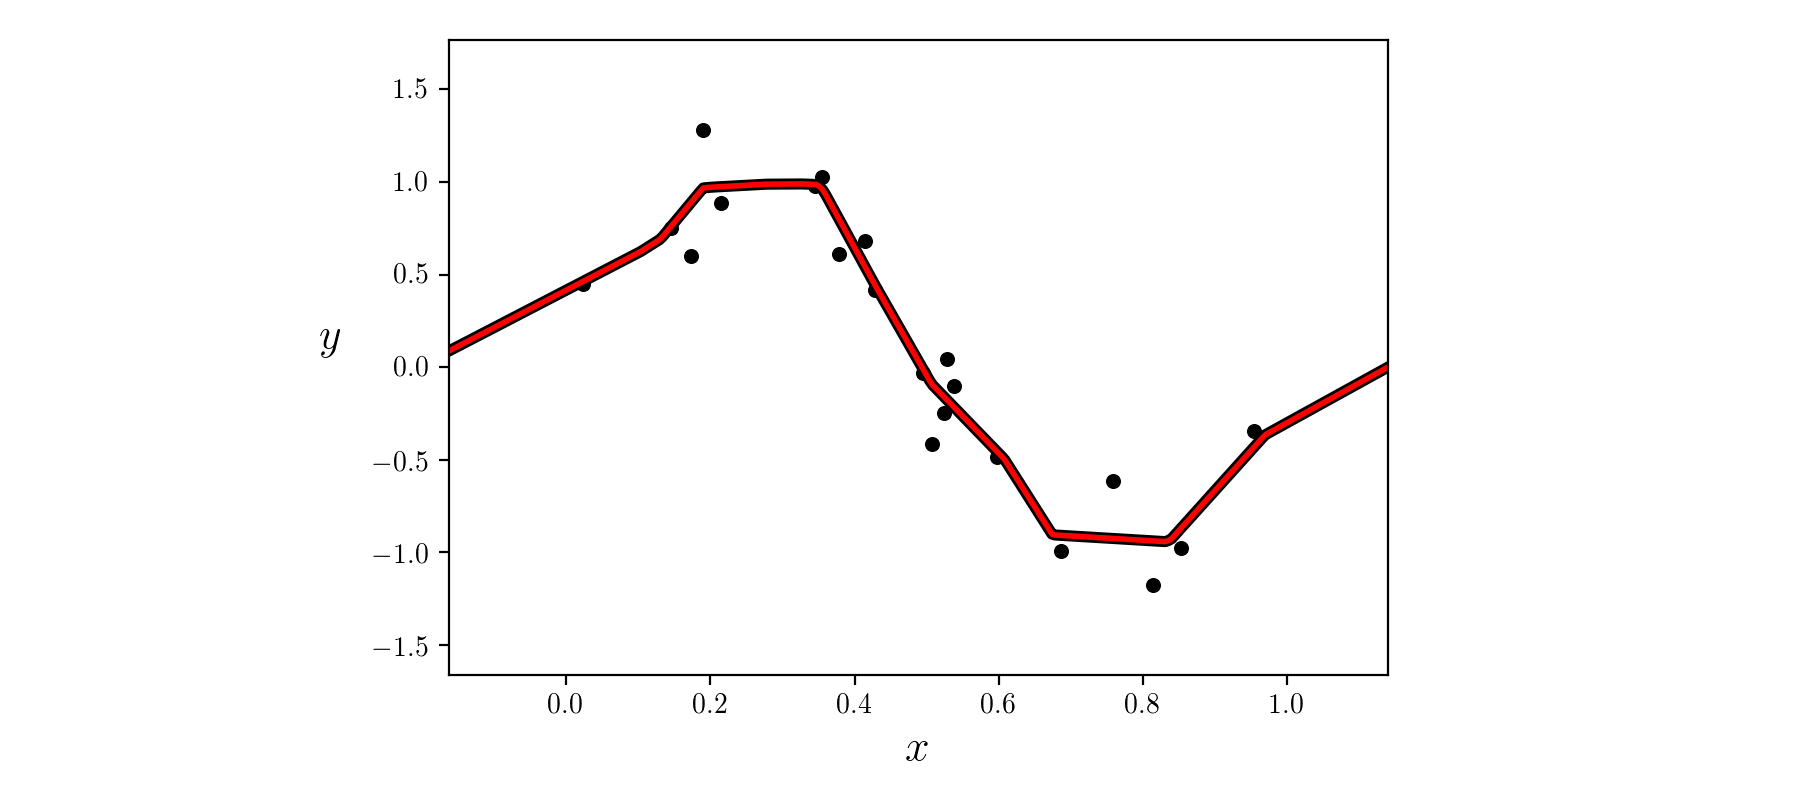

In [170]:
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(mylib4.train_cost_histories[0])
w_best = mylib4.weight_histories[0][ind]
demo4 = regress_plotter.Visualizer(data)
demo4.plot_fit(w_best,mylib4.model,normalizer = mylib4.normalizer);

#### <span style="color:#a50e3e;">Example 10. </span>  Nonlinear two-class classification example using multilayer perceptrons

Here we use a network architecture to perform nonlinear classification using the following toy dataset.  The dataset is shown 'from above' in the left panel, where red points belong to class $+1$ and blue points to class $-1$, and from the side in the right panel.

<IPython.core.display.Javascript object>


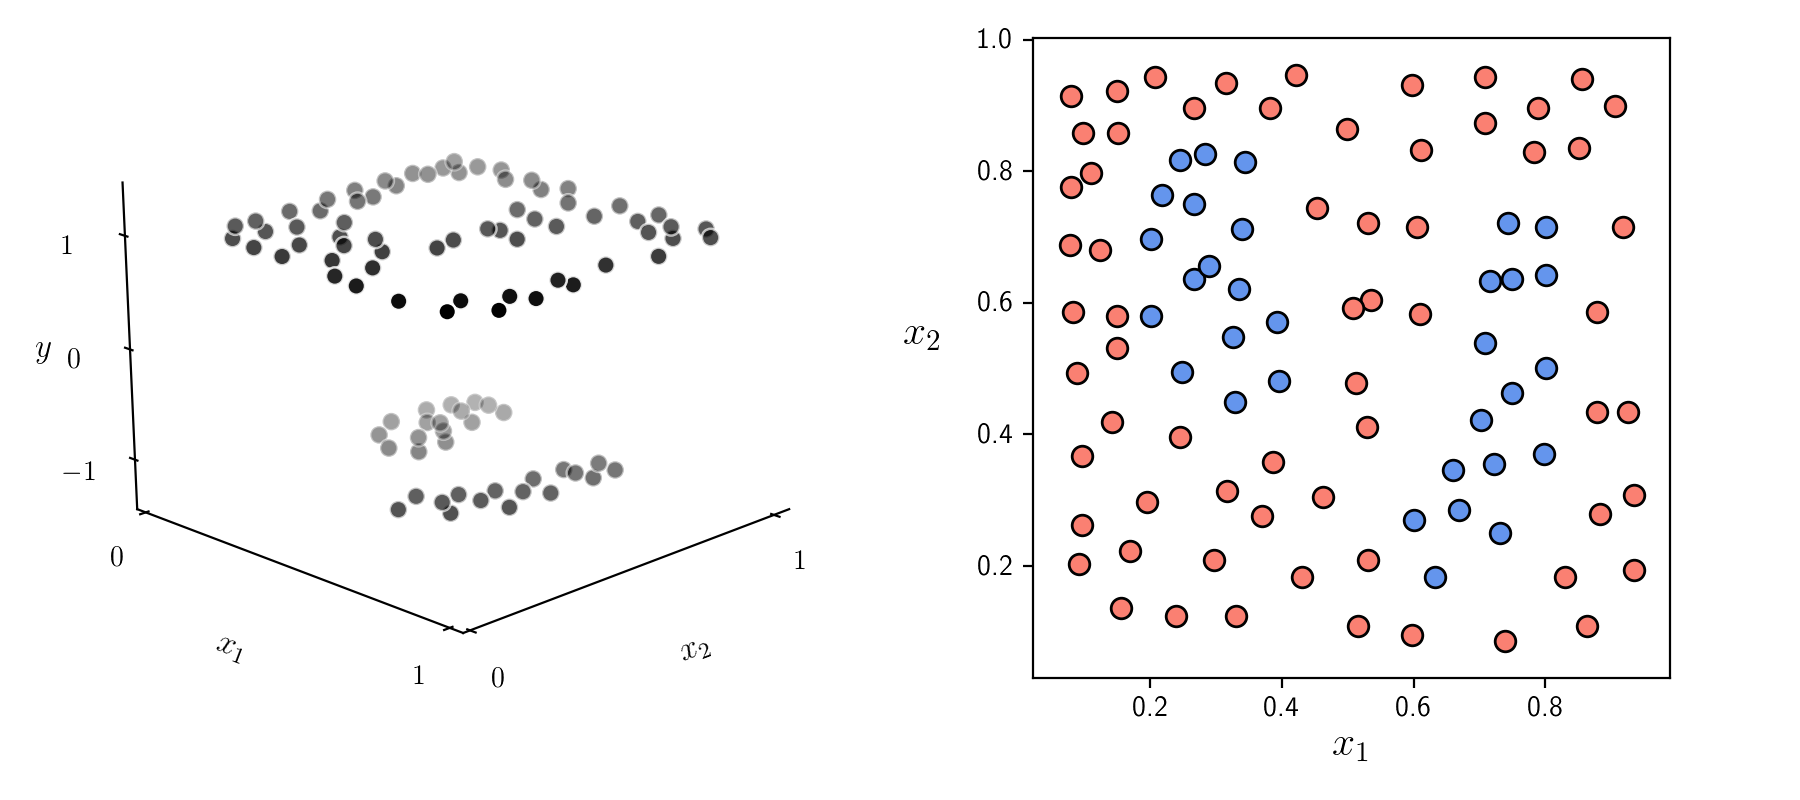

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# create instance of linear regression demo, used below and in the next examples
demo5 = multi.nonlinear_classification_visualizer.Visualizer(datapath + '2_eggs.csv')
x = demo5.x.T
y = demo5.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo5.plot_data();

We will use the same network architecture used in the previous regression example here - 4 hidden layers with 10 units in each layer.  Below we initialize the network, mirroring this step in the previous example.

In [ ]:
# An example 4 hidden layer network, with 10 units in each layer
N = 2  # dimension of input
M = 1  # dimension of output
U_1 = 10; U_2 = 10; U_3 = 10;  # number of units per hidden layer

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w = initialize_network_weights(layer_sizes, scale = 0.5)

Now we can tune the weights of our network architecture using a ``softmax`` (or logistic) cost function, minimizing the result via gradient descent.

<IPython.core.display.Javascript object>


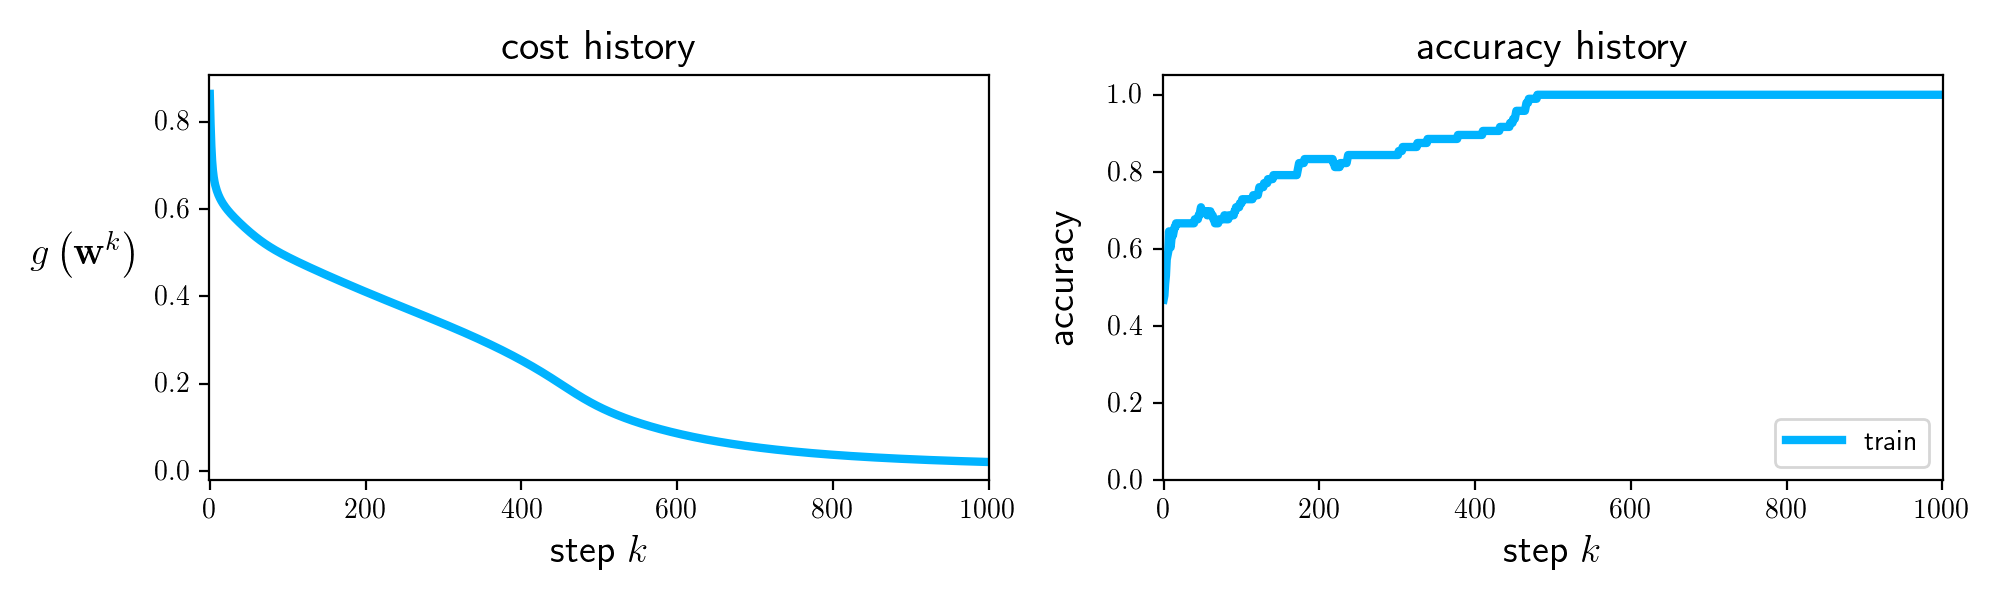

In [5]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib5 = multi.basic_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib5.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib5.make_train_val_split(train_portion = 1)

# choose cost
mylib5.choose_cost(name = 'softmax')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10,10,10]
mylib5.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh',scale = 0.5)

# fit an optimization
mylib5.fit(max_its = 1000,alpha_choice = 10**(-1),verbose = False)

# plot cost function history
mylib5.show_histories()

Finally, we visualize the fit provided by the final weights learned via gradient descent.  Here it is harder to visually determine whether or not we have overfit when viewing the fit from above (in the left panel), since points from the two classes are so nicely separable by closed curves.  However when you look at the fit from the side (in the right panel) you can see how the learned surface is extremely ripply (a sign that we overkilled this particular dataset using such a flexible network).

<IPython.core.display.Javascript object>


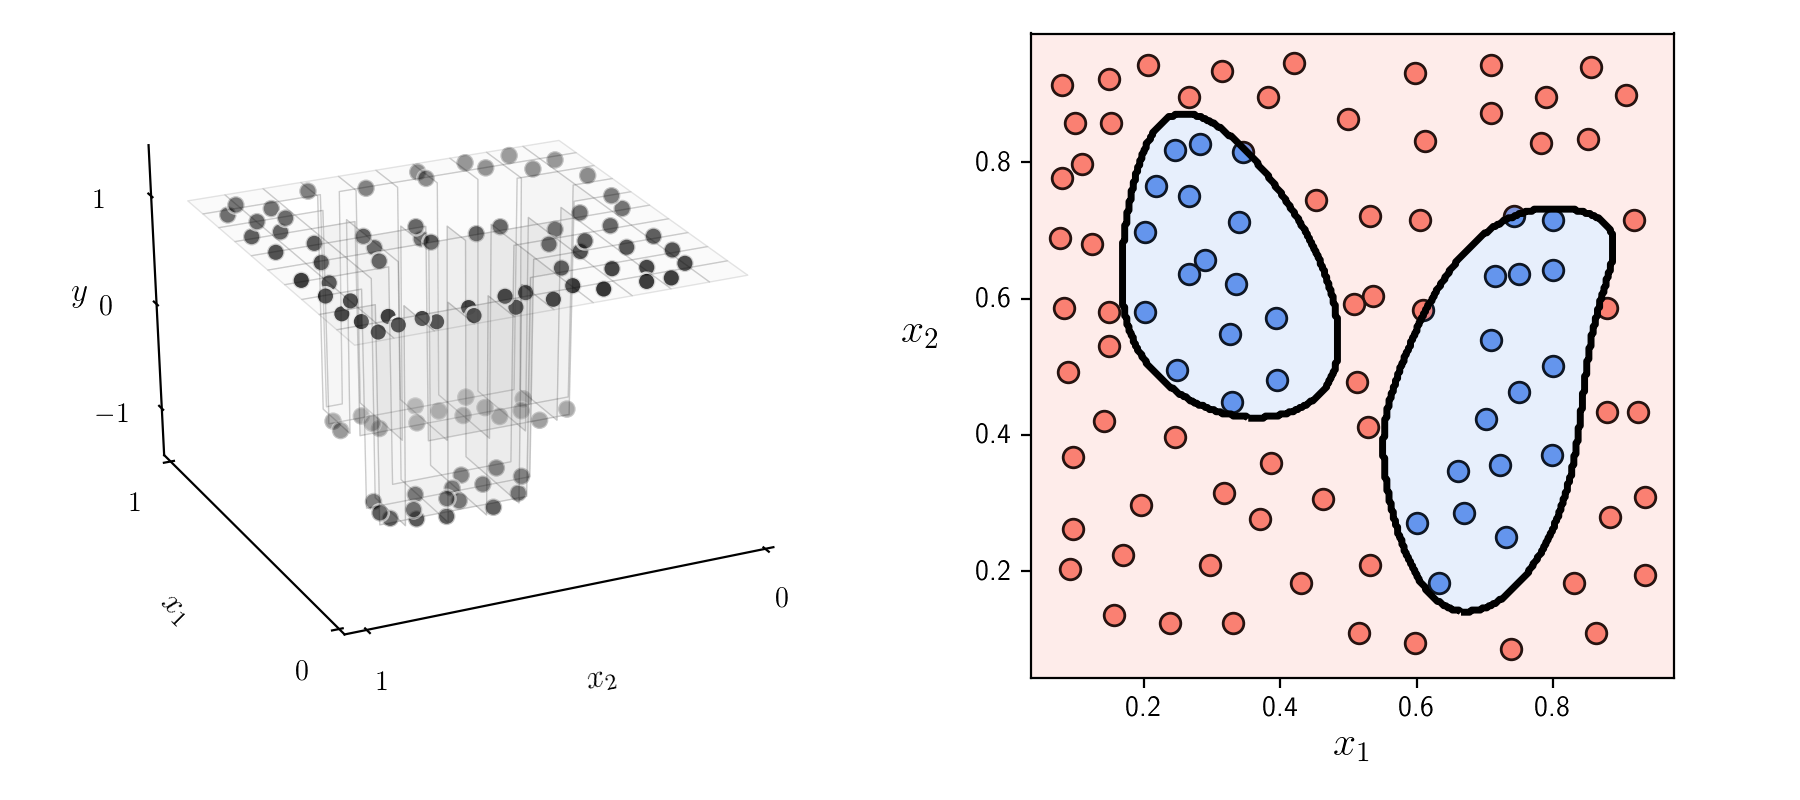

In [6]:
# This code cell will not be shown in the HTML version of this notebook
# illustrate results
ind = np.argmax(mylib5.train_accuracy_histories[0])
w_best = mylib5.weight_histories[0][ind]
demo5.static_N2_simple(w_best,mylib5,view = [30,155])

#### <span style="color:#a50e3e;">Example 11. </span>  Learning a nonlinear manifold using multilayer perceptron encoding/decoding functions

In this example we illustrate the use of multilayer perceptrons for both the `encoder` $f_{\text{e}}$ and `decoder` $f_{\text{d}}$ a general autoencoder function (see e.g., Section 12.3 for an introduction to the nonlinear autoencoder).  Here for both functions we will use a 3 layer multilayer perceptron with 10 units in each layer and the `tanh` activation.  We will then tune the parameters of both functions by minimizing the autoencoder cost function to uncover the proper nonlinear manifold on which the following dataset sits.

<IPython.core.display.Javascript object>


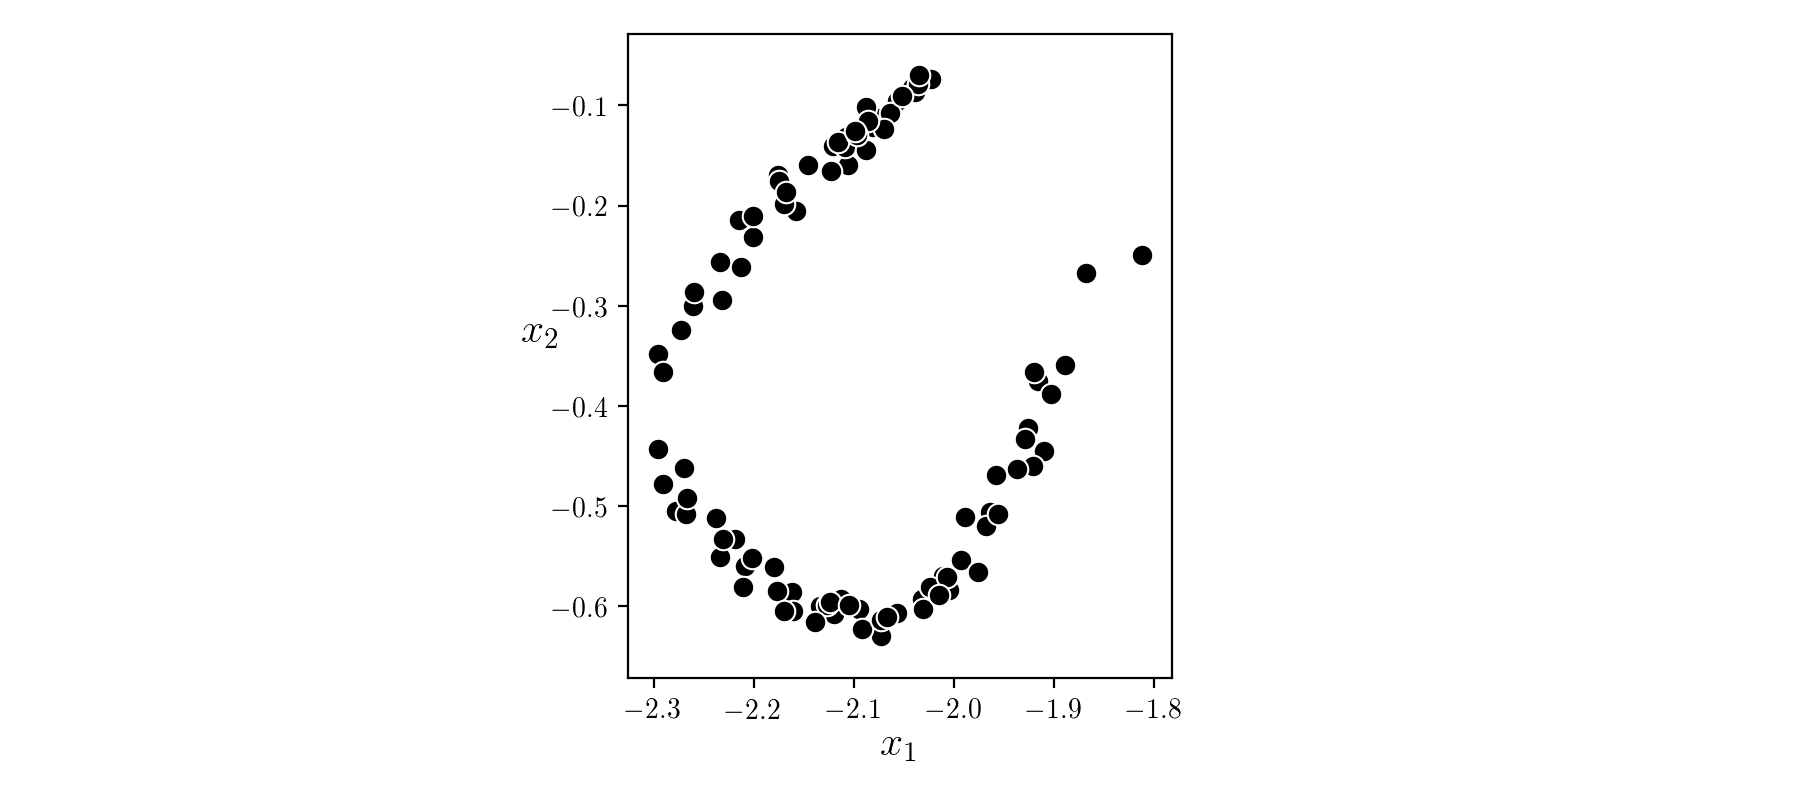

In [7]:
# This code cell will not be shown in the HTML version of this notebook
# import data
X = np.loadtxt(datapath + 'universal_autoencoder_samples.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

Below we initialize two multilayer perceptrons - one for each of the encoding and ecoding function.

In [ ]:
### initialize encoder network ###
N = 2  # dimension of input
M = 1  # dimension of output
U_1 = 10; U_2 = 10; U_3 = 10;  # number of units per hidden layer

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w_encoder = initialize_network_weights(layer_sizes, scale = 0.5)

### initialize decoder network ###
N = 1  # dimension of input
M = 2  # dimension of output

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w_decoder = initialize_network_weights(layer_sizes, scale = 0.5)

# gather initializations for both encoder and encoder, package into single list
w = [w_encoder,w_decoder]

With our encoder and decoder constructed and initialized, we then minimize the corresponding autoencoder cost function over the dataset.

<IPython.core.display.Javascript object>


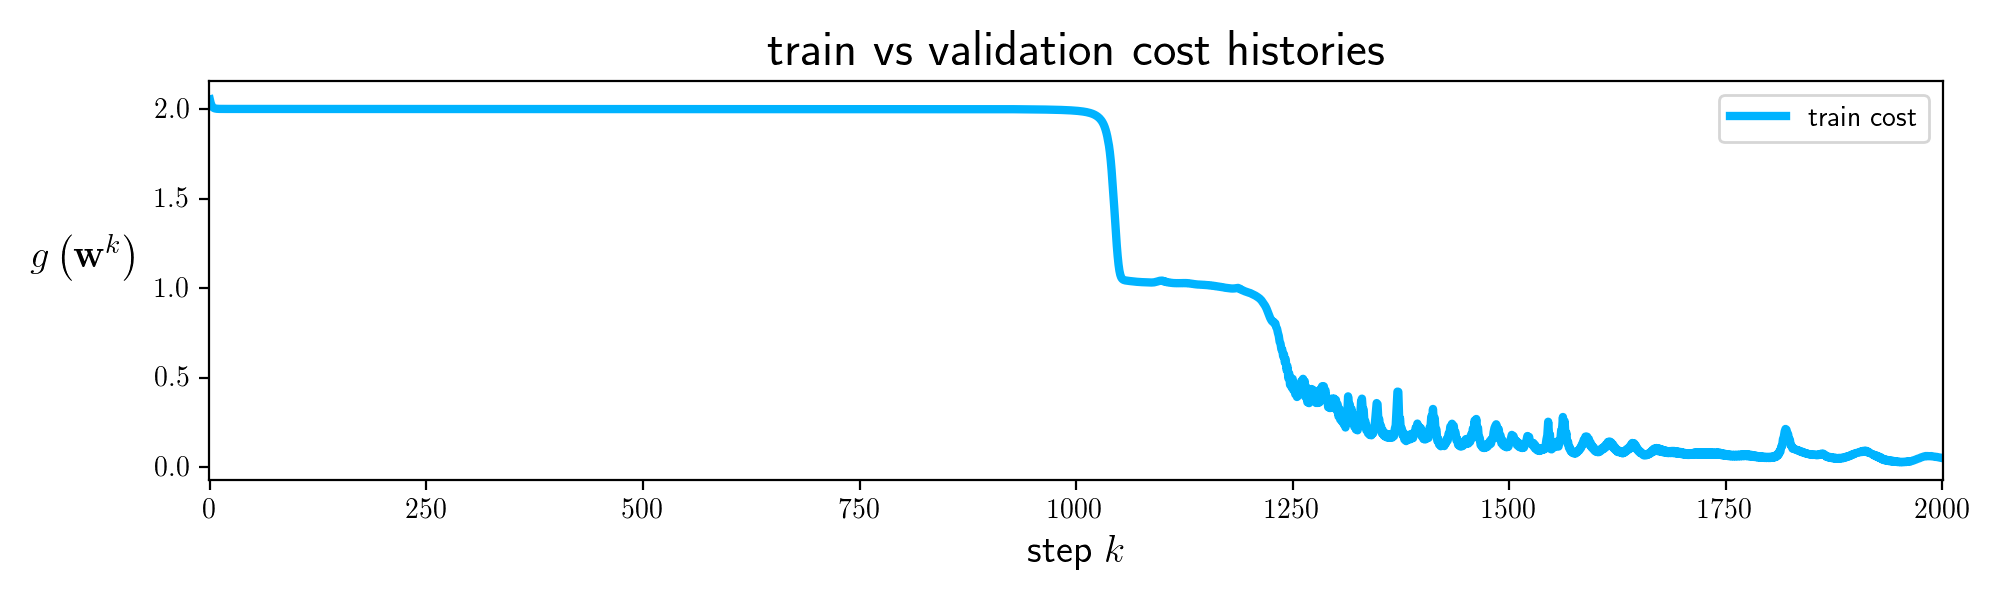

In [17]:
# This code cell will not be shown in the HTML version of this notebook
# create instance of library
mylib6 = multi.basic_lib.unsuper_setup.Setup(X)

# perform preprocessing step(s) - especially input normalization
mylib6.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib6.make_train_val_split(train_portion = 1)

# choose features
mylib6.choose_encoder(layer_sizes = [2,10,10,1],scale = 0.2)
mylib6.choose_decoder(layer_sizes = [1,10,10,2],scale = 0.2)

# choose cost
mylib6.choose_cost(name = 'autoencoder')

# fit an optimization
mylib6.fit(max_its = 2000,alpha_choice = 10**(-1),verbose = False)

# plot cost function history
mylib6.show_histories()

Having minimized the cost function appropriately we can now visualize the learned manifold (middle panel below) and the decoded version of the original dataset (right panel below) - i.e., the original dataset projected onto our learned manifold.  We can also visualize how all of the data in this space is projected onto the learned manifold via a vector field plot, which we do in the bottom panel.

<IPython.core.display.Javascript object>


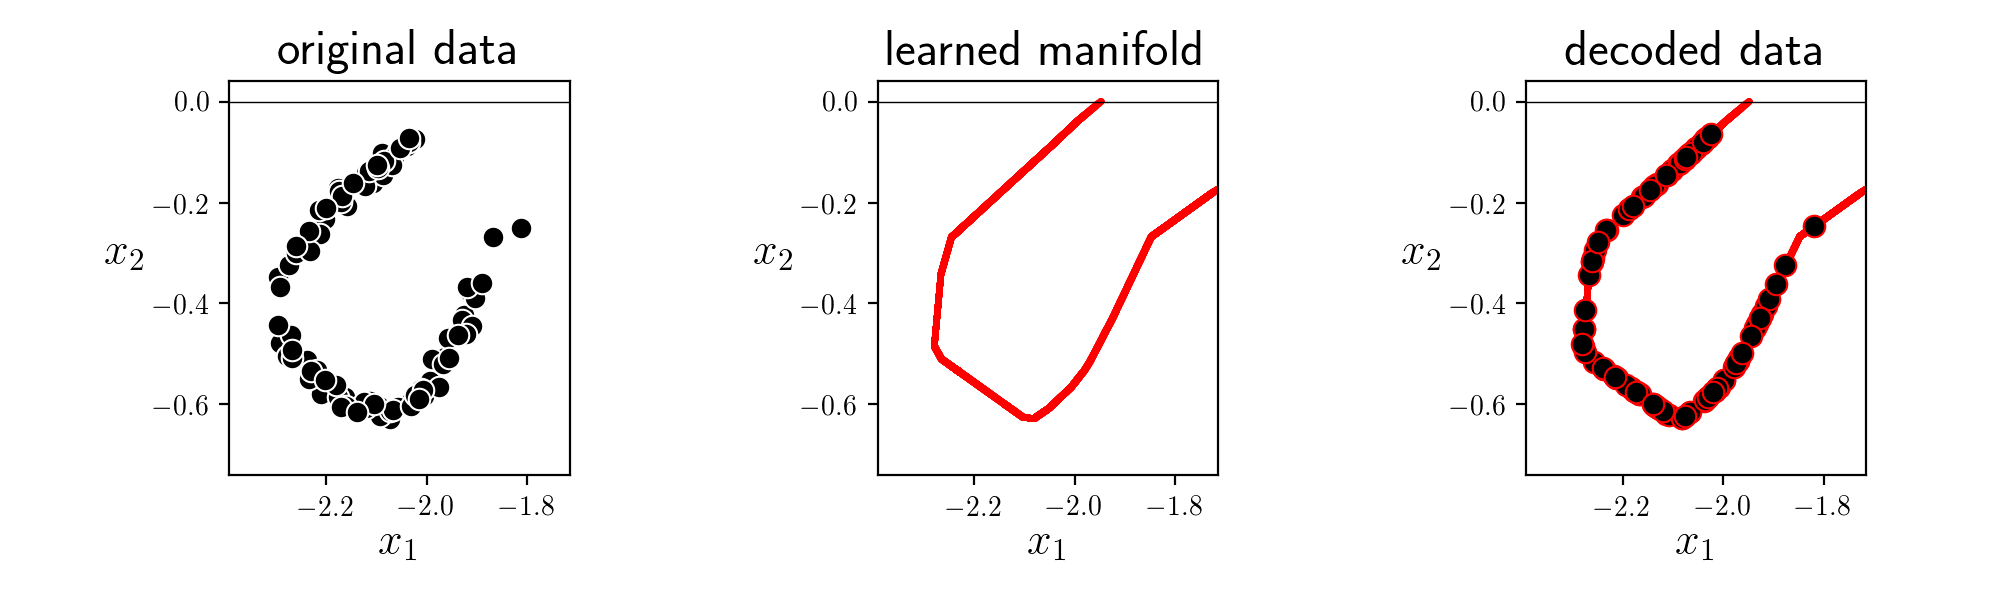

<IPython.core.display.Javascript object>


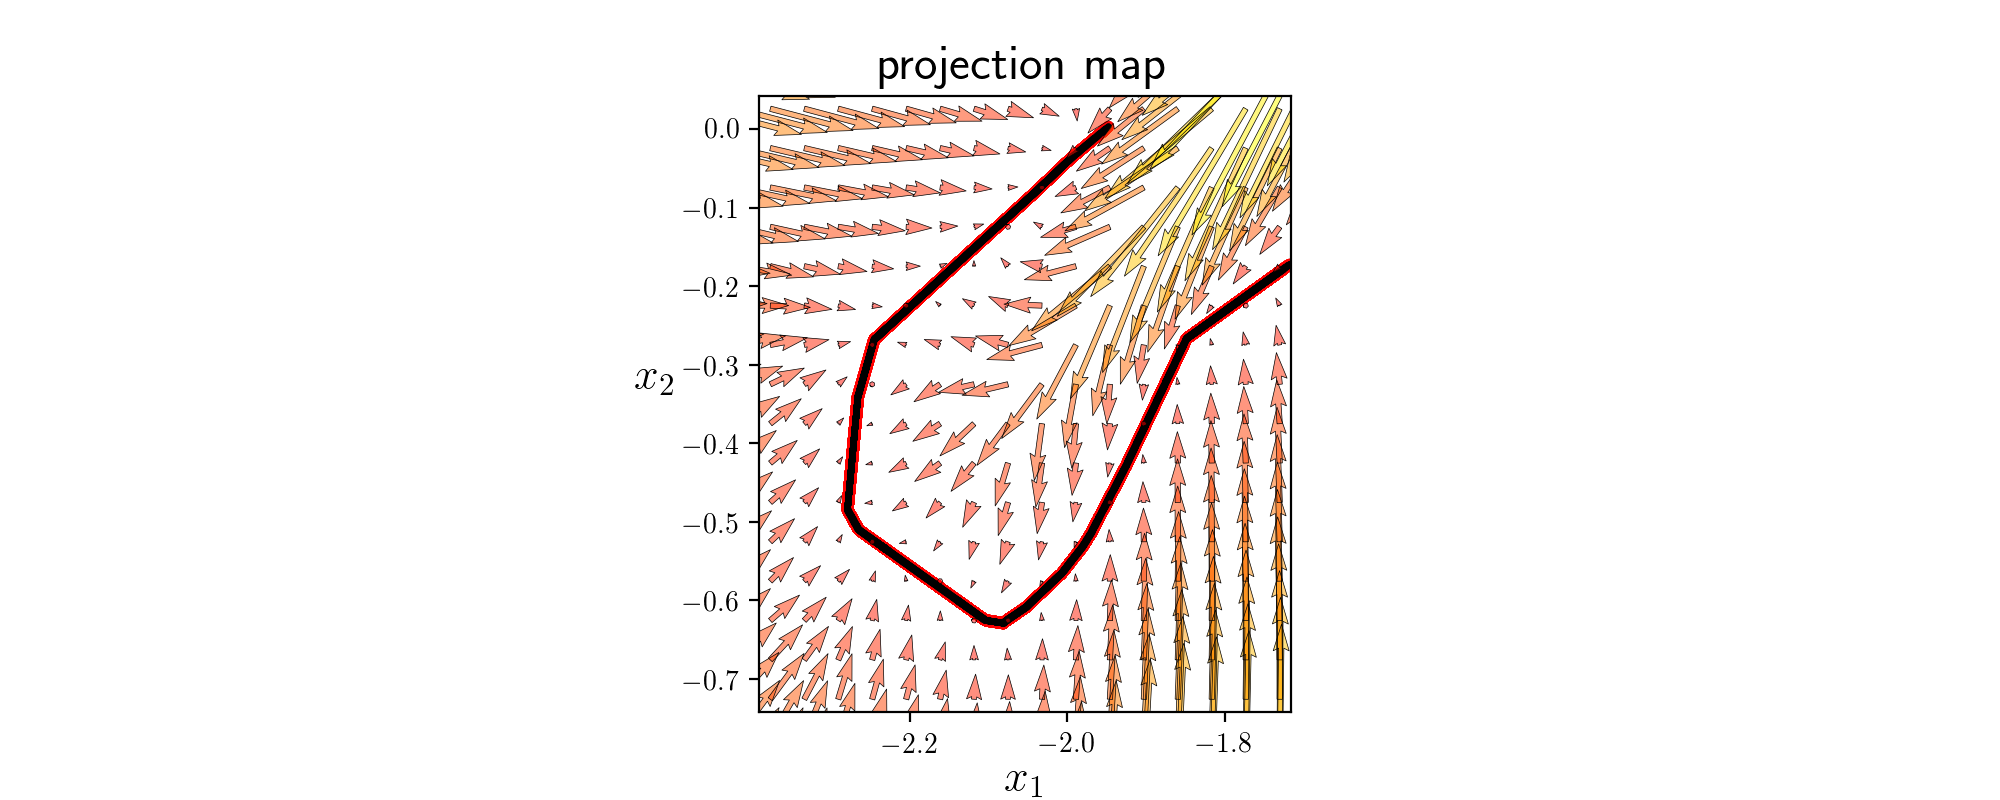

In [18]:
# This code cell will not be shown in the HTML version of this notebook
# plot results
multi.autoencoder_demos.show_encode_decode(X,mylib6,projmap = True,scale = 4.5)

<a id='bib_cell'></a>

## References

[1]  W. S. McCulloch and W. Pitts. A logical calculus of the ideas immanent in nervous activity. The bulletin of mathematical biophysics, 5(4):115–133, 1943.

[2]  D. O. Hebb. The organization of behavior: a neuropsychological theory. John Wiley & Sons, New York, 1949.

[3]  F. Rosenblatt. The perceptron - a perceiving and recognizing automaton. Cornell Aeronautical Laboratory, 1957.

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.